# DATASET

In [2]:
# Test imports
import os
import json
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, random_split, Dataset
from scipy import io
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter
import torch
from matplotlib.path import Path
import matplotlib.pyplot as plt
from monai.transforms import CropForeground, SpatialCrop
import numpy as np
import math
from itertools import product

print("All imports work correctly!")

All imports work correctly!


In [3]:
# Define a custom 3D dataset for testing purposes
class SwinUnetr3DDataset(Dataset):
    def __init__(self, is_inference_mode: bool, metadata_dict_with_files_selected: dict, data_dir: str, model_input_dim: tuple, overlap):
        """
        Initializes the class instance with the provided parameters.

        Parameters:
        metadata_dict_with_files_selected (dict): Dictionary containing the selected files for the dataset with their metadata (e.g., 3D_thermal_sequence_filename, label_filename, ROI, stratified group, etc.).
        data_dir (str): Directory where the data is located.
        model_input_dim (tuple): 3D tuple indicating the dimensions of the model input (height, width, depth).
        """

        self.metadata_dict_with_files_selected = metadata_dict_with_files_selected
        self.data_dir = data_dir

        self.is_inference_mode = is_inference_mode # e.g. False

        self.model_input_dim = model_input_dim #e.g. (64,64,128)

        self.overlap = overlap #e.g. [0.25,0.35]
        formatted_overlap_dim_0 = f"{self.overlap[0]:.2f}"
        formatted_overlap_dim_1 = f"{self.overlap[1]:.2f}"

        self.patch_size = f"{self.model_input_dim[0]}x{self.model_input_dim[1]}" #e.g. 64x64
        self.overlap_key = f"{formatted_overlap_dim_0.replace('.', '_')}x{formatted_overlap_dim_1.replace('.', '_')}" #e.g. 0_25x0_35

        self.preprocessed_dir = os.path.join(os.getcwd(), self.data_dir, "preprocessed_files")
        self.preprocessed_info_json_path = os.path.join(self.preprocessed_dir, "preprocessed_info.json")
        self.preprocessed_info_dict = None

        self.preprocessed_patches_dataset = []

        # ########################### PREPROCESSING (AND DISK SAVING) ###########################

        if os.path.isdir(self.preprocessed_dir):
            print(f"The directory '{self.preprocessed_dir}' exists.")
        else:
            os.makedirs(self.preprocessed_dir)
            print(f"The directory '{self.preprocessed_dir}' did not exist and has been created.")

        if os.path.isfile(self.preprocessed_info_json_path):
            print(f"The json file '{self.preprocessed_info_json_path}' exists.")
            self.preprocessed_info_dict = self.load_preprocessed_info()
        else:
            self.preprocessed_info_dict = {}


        for sample_id, sample_metadata in self.metadata_dict_with_files_selected.items():
            # Checks
            if sample_id in self.preprocessed_info_dict:
                print(f"The label and measurement corresponding to '{sample_id}' sample have already been processed at least once.")
            else:
                # Create directory for the sample
                preprocessed_sample_dir = os.path.join(self.preprocessed_dir, f"{sample_id}")
                os.makedirs(preprocessed_sample_dir)
                print(f"The directory '{preprocessed_sample_dir}' did not exist and has been created.")
                preprocessed_sample_label_dir = os.path.join(preprocessed_sample_dir, "label")
                os.makedirs(preprocessed_sample_label_dir)
                print(f"The directory '{preprocessed_sample_label_dir}' did not exist and has been created.")
                preprocessed_sample_label_patches_dir = os.path.join(preprocessed_sample_dir, "label", "patches")
                os.makedirs(preprocessed_sample_label_patches_dir)
                print(f"The directory '{preprocessed_sample_label_patches_dir}' did not exist and has been created.")
                preprocessed_sample_measurement_dir = os.path.join(preprocessed_sample_dir, "measurement")
                os.makedirs(preprocessed_sample_measurement_dir)
                print(f"The directory '{preprocessed_sample_measurement_dir}' did not exist and has been created.")
                # Create and save the cropped label in the directory just created
                cropped_label_tensor, cropped_bbox_info = self.load_and_crop_label(sample_id, sample_metadata)
                cropped_label_tensor_filename = os.path.join(preprocessed_sample_label_dir,f"{sample_id}_cropped_label.pt")
                torch.save(cropped_label_tensor, cropped_label_tensor_filename)
                # Update the information in the preprocessed_info_json
                self.update_dictionary(self.preprocessed_info_dict, sample_id, {})
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "measurement" ,{})
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "label" ,{})
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "cropped_bbox_info", cropped_bbox_info)
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "label" ,"cropped_label_tensor_filename", cropped_label_tensor_filename)
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "label" ,"patches", {})

            #Check depth directory for measurement
            if f"depth[{self.model_input_dim[2]}]" in self.preprocessed_info_dict[sample_id]["measurement"]:
                print(f"The measurement corresponding to '{sample_id}' sample have already been processed with depth [{self.model_input_dim[2]}] at least once.")
            else:
                # Create directory for the depth we will apply inside the measurement directory
                measurement_depth_dir = os.path.join(self.preprocessed_dir, f"{sample_id}", "measurement", f"depth[{self.model_input_dim[2]}]")
                os.makedirs(measurement_depth_dir)
                print(f"The directory '{measurement_depth_dir}' did not exist and has been created.")
                measurement_depth_patches_dir = os.path.join(measurement_depth_dir, "patches")
                os.makedirs(measurement_depth_patches_dir)
                print(f"The directory '{measurement_depth_patches_dir}' did not exist and has been created.")
                # Create and save the cropped, standarized & depth compressed 3D measurement in the directory just created
                cropped_standarized_depth_compressed_measurement_tensor = self.load_crop_standardize_depth_compress_measurement(sample_id, sample_metadata)
                cropped_standarized_depth_compressed_measurement_tensor_filename = os.path.join(measurement_depth_dir, f"{sample_id}_cropped_standarized_depth[{self.model_input_dim[2]}].pt")
                torch.save(cropped_standarized_depth_compressed_measurement_tensor, cropped_standarized_depth_compressed_measurement_tensor_filename)
                # Update the information in the preprocessed_info_json
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "measurement", f"depth[{self.model_input_dim[2]}]", {})
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "measurement", f"depth[{self.model_input_dim[2]}]", "cropped_standarized_depth_compressed_measurement_tensor_filename", cropped_standarized_depth_compressed_measurement_tensor_filename)
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "measurement", f"depth[{self.model_input_dim[2]}]", "patches", {})

            #Check patches_size directory for label
            if  f"patch_size[{self.patch_size}]" in self.preprocessed_info_dict[sample_id]["label"]["patches"]:
                print(f"The label corresponding to '{sample_id}' sample have already been processed with patch size [{self.patch_size}] at least once.")
            else:
                label_patches_size_dir = os.path.join(self.preprocessed_dir, f"{sample_id}", "label", "patches", f"patch_size[{self.patch_size}]")
                os.makedirs(label_patches_size_dir)
                print(f"The directory '{label_patches_size_dir}' did not exist and has been created.")
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "label", "patches", f"patch_size[{self.patch_size}]", {})

            #Check patches_size directory for measurement
            if  f"patch_size[{self.patch_size}]" in self.preprocessed_info_dict[sample_id]["measurement"][f"depth[{self.model_input_dim[2]}]"]["patches"]:
                print(f"The measurement corresponding to '{sample_id}' sample have already been processed with depth [{self.model_input_dim[2]}] and patch size [{self.patch_size}] at least once.")
            else:
                measurement_depth_patches_size_dir = os.path.join(self.preprocessed_dir, f"{sample_id}", "measurement", f"depth[{self.model_input_dim[2]}]", "patches", f"patch_size[{self.patch_size}]")
                os.makedirs(measurement_depth_patches_size_dir)
                print(f"The directory '{measurement_depth_patches_size_dir}' did not exist and has been created.")
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "measurement", f"depth[{self.model_input_dim[2]}]", "patches", f"patch_size[{self.patch_size}]", {})


            #LABEL_PATCHES
            if f"overlap[{self.overlap_key}]" in self.preprocessed_info_dict[sample_id]["label"]["patches"][f"patch_size[{self.patch_size}]"]:
                print(f"The label corresponding to '{sample_id}' sample have already been processed with patch size [{self.patch_size}] and overlap [{self.overlap_key}]")
            else:
                label_overlap_dir = os.path.join(self.preprocessed_dir, f"{sample_id}", "label", "patches", f"patch_size[{self.patch_size}]", f"overlap[{self.overlap_key}]")
                os.makedirs(label_overlap_dir)
                print(f"The directory '{label_overlap_dir}' did not exist and has been created.")
                cropped_bbox_info = self.preprocessed_info_dict[sample_id]["cropped_bbox_info"]
                cropped_label_tensor_filename = self.preprocessed_info_dict[sample_id]["label"]["cropped_label_tensor_filename"]
                cropped_label_tensor = torch.load(cropped_label_tensor_filename, weights_only=True)
                label_patches = self.create_patches(cropped_label_tensor, sample_metadata["ROI"], cropped_bbox_info)

                label_patches_dictionary = {}
                # Save patches
                for i, label_patch in enumerate(label_patches):
                    label_tensor_patch, label_tensor_patch_coord, roi_adjusted_patch = label_patch
                    preprocessed_label_patch_filename = os.path.join(f"label_{sample_id}_patch_size[{self.patch_size}]_overlap[{self.overlap_key}]_coords[{label_tensor_patch_coord[0]}x{label_tensor_patch_coord[1]}].pt")
                    patch_patch= os.path.join(label_overlap_dir, preprocessed_label_patch_filename)
                    torch.save(label_tensor_patch, patch_patch)
                    label_patches_dictionary["_".join(map(str, label_tensor_patch_coord))] = {
                        "patch_coord": label_tensor_patch_coord,
                        "patch_path": patch_patch,
                        "roi_adjusted_patch": roi_adjusted_patch
                    }
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "label", "patches", f"patch_size[{self.patch_size}]", f"overlap[{self.overlap_key}]", label_patches_dictionary)

            #MEASUREMENT_PATCHES
            if f"overlap[{self.overlap_key}]" in self.preprocessed_info_dict[sample_id]["measurement"][f"depth[{self.model_input_dim[2]}]"]["patches"][f"patch_size[{self.patch_size}]"]:
                print(f"The measurement corresponding to '{sample_id}' sample have already been processed with depth [{self.model_input_dim[2]}], patch size [{self.patch_size}] and overlap [{self.overlap_key}]")
            else:
                measurement_overlap_dir = os.path.join(self.preprocessed_dir, f"{sample_id}", "measurement", f"depth[{self.model_input_dim[2]}]","patches", f"patch_size[{self.patch_size}]", f"overlap[{self.overlap_key}]")
                os.makedirs(measurement_overlap_dir)
                print(f"The directory '{measurement_overlap_dir}' did not exist and has been created.")
                cropped_bbox_info = self.preprocessed_info_dict[sample_id]["cropped_bbox_info"]
                cropped_standarized_depth_compressed_measurement_tensor_filename = self.preprocessed_info_dict[sample_id]["measurement"][f"depth[{self.model_input_dim[2]}]"]["cropped_standarized_depth_compressed_measurement_tensor_filename"]
                cropped_standarized_depth_compressed_measurement_tensor = torch.load(cropped_standarized_depth_compressed_measurement_tensor_filename, weights_only=True)
                measurement_patches = self.create_patches(cropped_standarized_depth_compressed_measurement_tensor, sample_metadata["ROI"], cropped_bbox_info)

                measurement_patches_dictionary = {}
                # Save patches
                for i, measurement_patch in enumerate(measurement_patches):
                    measurement_tensor_patch, measurement_tensor_patch_coord, roi_adjusted_patch = measurement_patch
                    preprocessed_measurement_patch_filename = os.path.join(f"{sample_id}_depth[{self.model_input_dim[2]}]_patch_size[{self.patch_size}]_overlap[{self.overlap_key}]_coords[{measurement_tensor_patch_coord[0]}x{measurement_tensor_patch_coord[1]}].pt")
                    patch_patch = os.path.join(measurement_overlap_dir, preprocessed_measurement_patch_filename)
                    torch.save(measurement_tensor_patch, patch_patch)
                    measurement_patches_dictionary["_".join(map(str, measurement_tensor_patch_coord))] = {
                        "patch_coord": measurement_tensor_patch_coord,
                        "patch_path": patch_patch,
                        "roi_adjusted_patch": roi_adjusted_patch
                    }
                self.update_dictionary(self.preprocessed_info_dict, sample_id, "measurement", f"depth[{self.model_input_dim[2]}]", "patches", f"patch_size[{self.patch_size}]", f"overlap[{self.overlap_key}]", measurement_patches_dictionary)

            label_patches_dict = self.preprocessed_info_dict[sample_id]["label"]["patches"][f"patch_size[{self.patch_size}]"][f"overlap[{self.overlap_key}]"]
            measurement_patches_dict = self.preprocessed_info_dict[sample_id]["measurement"][f"depth[{self.model_input_dim[2]}]"]["patches"][f"patch_size[{self.patch_size}]"][f"overlap[{self.overlap_key}]"]
            for (key1, value1), (key2, value2) in zip(label_patches_dict.items(), measurement_patches_dict.items()):
                self.preprocessed_patches_dataset.append(
                    {
                        "sample_id": sample_id,
                        "coord": key1, # Key 1 and Key 2 are equal
                        "patch_label_info": value1,
                        "patch_measurement_info": value2
                    }
                )

        self.update_preprocessed_info() #Updates "preprocessed_info.json"


    def load_preprocessed_info(self):
        # If it exists, attempt to load existing data from the file
        with open(self.preprocessed_info_json_path, 'r') as file:
            try:
                preprocessed_info_dict = json.load(file)  # Load JSON data into a dictionary
            except json.JSONDecodeError:
                raise ValueError(
                    f"The JSON file '{self.preprocessed_info_json_path}' is corrupted or not formatted correctly."
                )
        return preprocessed_info_dict


    def update_preprocessed_info(self):
        ## Rewrite JSON in disk
        with open(self.preprocessed_info_json_path, 'w') as file:
            json.dump(self.preprocessed_info_dict, file, indent=4)  # The indent parameter makes it human-readable

        print(f"The JSON file '{self.preprocessed_info_json_path}' has been updated.")


    def update_dictionary(self, dictionary, *args):
        # If it's just a key-value pair
        if len(args) == 2:
            if args[0] not in dictionary:
                dictionary[args[0]] = args[1]
            else:
                dictionary[args[0]].update(args[1])
        else:
            current_level = dictionary
            # Iterate through all but the last argument to handle nested keys
            for key in args[:-2]:
                current_level = current_level[key]  # Move deeper into the nested dictionary

            # The last two arguments are the final key-value pair to update
            final_key, final_value = args[-2], args[-1]

            if final_key not in current_level:
                current_level[final_key] = final_value
            else:
                current_level[final_key].update(final_value)


    def create_patches(self, cropped_tensor, ROI_coordinates, cropped_bbox_info):

        for i in range(2):  # Check for i=0 (height) and i=1 (width)
            cropped_dim = cropped_tensor.shape[i + 1]  # i+1 due to channel in dim 0
            required_dim = self.model_input_dim[i]

            if cropped_dim - required_dim == 0:
                continue  # Dimension matches exactly; no issue
            elif cropped_dim - required_dim > 0:
                continue  # Cropped dimension is larger than required
            else:
                raise ValueError(
                    f"The cropped ROI area is too small for the predefined patch size. "
                    f"Dimension {i} mismatch: cropped ROI area dimension {i} = {cropped_dim} "
                    f"vs. patch dimension {i} = {required_dim}."
                )

        slices_per_dim = {}

        for i in range(2):  # Check for i=0 (height) and i=1 (width)
            stride = int(self.model_input_dim[i] * (1-self.overlap[i]))
            print(f"Dim {i} - Stride: {stride}")
            print(f"Dim {i} - Model Input Dim: {self.model_input_dim[i]}")
            print(f"Dim {i} - Cropped Tensor Shape: {cropped_tensor.shape[i + 1]}")
            slices = []
            for j in range(0, cropped_tensor.shape[i + 1], stride):
                slice_start = j
                slice_end = j + self.model_input_dim[i]
                if slice_end <= cropped_tensor.shape[i + 1]:
                    slice_to_add = slice(slice_start, slice_end)
                    print(f"Dim {i} - Slice: {slice_to_add}")
                    slices.append(slice_to_add)
                else:
                    out_of_bounds = slice_end - cropped_tensor.shape[i + 1]
                    slice_to_add = slice(slice_start - out_of_bounds, slice_end - out_of_bounds)
                    if not slice_to_add in slices:
                      print(f"Dim {i} - Slice: {slice_to_add}")
                      slices.append(slice_to_add)
                    else:
                      break
            slices_per_dim[i] = slices

        # Get the lists of slices
        slices_height_dim = slices_per_dim[0]
        slices_width_dim = slices_per_dim[1]

        # Generate all combinations (Cartesian product) of slices between both dimensions
        patches_slices = list(product(slices_height_dim, slices_width_dim))

        # List to store the resulting patches
        patches_list = []

        # Iterate over all the patches
        for patch_slices in patches_slices:
            patch_slice_height_dim = patch_slices[0]
            patch_slice_width_dim = patch_slices[1]

            roi_start = (patch_slice_height_dim.start, patch_slice_width_dim.start)

            if len(cropped_tensor.shape) == 3: # Label tensor
                patch_tensor = cropped_tensor[:, patch_slice_height_dim, patch_slice_width_dim]
            else: # Measurement tensor
                patch_tensor = cropped_tensor[:, patch_slice_height_dim, patch_slice_width_dim, :]

            roi_coords_in_cropped_tensor = {
                'all_points_x': [x - cropped_bbox_info["x_coord"] for x in ROI_coordinates['all_points_x']],
                'all_points_y': [y - cropped_bbox_info["y_coord"] for y in ROI_coordinates['all_points_y']]
            }

            roi_adjusted_patch = {
                'all_points_x': [x - roi_start[1] for x in roi_coords_in_cropped_tensor['all_points_x']],
                'all_points_y': [y - roi_start[0] for y in roi_coords_in_cropped_tensor['all_points_y']]
            }
            # Append the cropped tensor and adjusted ROI to the list
            patches_list.append((patch_tensor, (roi_start[0], roi_start[1]), roi_adjusted_patch))

        if len(cropped_tensor.shape) == 3: # Label tensor
                # Plotting Label Tensor Patches
                self.plot_patches(
                    patches_list,
                    tensor_type='Label',
                    channel=1,  # Specify the label channel (e.g., foreground)
                    cmap='RdBu',
                    number_slices_height_dim=len(slices_height_dim),
                    number_slices_width_dim=len(slices_width_dim)
                )
        else: # Measurement tensor
                # Plotting Measurement Tensor Patches
                self.plot_patches(
                    patches_list,
                    tensor_type='Measurement',
                    depth_frame=15,  # Specify the frame index
                    cmap='RdBu',
                    number_slices_height_dim=len(slices_height_dim),
                    number_slices_width_dim=len(slices_width_dim)
                )


        return patches_list

    def load_and_crop_label(self, measurement_id, measurement_data):
        measurement_label_filename = measurement_data["label_filename"]
        measurement_ROI = measurement_data["ROI"]

        # ############# LABEL LOADING ###################

        # Load label data
        label_img_ndarray = mpimg.imread(os.path.join(os.getcwd(), self.data_dir, "labels", measurement_label_filename))
        if len(label_img_ndarray.shape) == 3:
            label_img_ndarray = label_img_ndarray[..., 0] # Shape (256, 320)

        # ############# LABEL CONVERSION TO MULTI-CHANNEL (IT IS ADAPTED TO THE MODEL) ###################

        # Convert label to multi-channel for the model
        label_one_hot_encoded, label_mapping = self.one_hot_encode(label_img_ndarray)
        label_tensor = label_one_hot_encoded # Shape (2, 256, 320)

        self.plot_tensor_and_polygon(label_tensor, measurement_ROI, "Label Tensor")

        # ############# CROPPING LABEL USING MANUALLY DEFINED ROI ###################

        print(f"(Before cropping) label_tensor.shape: {label_tensor.shape}")

        # 1. Extract bounding box coordinates from ROI polygon
        x_coords = np.array(measurement_ROI['all_points_x'])
        y_coords = np.array(measurement_ROI['all_points_y'])

        x_min, x_max = int(x_coords.min()), int(x_coords.max())
        y_min, y_max = int(y_coords.min()), int(y_coords.max())

        # 2. Crop the tensor along height and width using the bounding box
        # Slicing along height (y-axis) and width (x-axis)
        cropped_label_tensor = label_tensor[:, y_min:y_max, x_min:x_max]

        cropped_bbox_info = {
            'y_coord': y_min,
            'x_coord': x_min,
            'height': y_max-y_min,
            'width': x_max-x_min,
        }

        ################### LOGGING #############################

        print(f"(After cropping) cropped_label_tensor.shape: {cropped_label_tensor.shape}")

        roi_coords_in_cropped_tensor = {
            'all_points_x': [x - x_min for x in measurement_ROI['all_points_x']],
            'all_points_y': [y - y_min for y in measurement_ROI['all_points_y']]
        }

        self.plot_tensor_and_polygon(cropped_label_tensor, roi_coords_in_cropped_tensor,"(Cropped) Label Tensor")

        return cropped_label_tensor, cropped_bbox_info

    def load_crop_standardize_depth_compress_measurement(self, measurement_id, measurement_data):
        measurement_3D_thermal_sequence_filename = measurement_data["3D_thermal_sequence_filename"]
        measurement_ROI = measurement_data["ROI"]

        # ############# 3D SEQUENCE DATA LOADING ###################

        # Load 3D sequence data
        mat_data = io.loadmat(os.path.join(os.getcwd(), self.data_dir, "data", measurement_3D_thermal_sequence_filename))
        measurement_3D_thermal_sequence = np.float32(mat_data["imageArray"])  # Shape (256, 320, 1810)
        measurement_tensor = torch.tensor(measurement_3D_thermal_sequence).unsqueeze(0)  # Shape (1, 256, 320, 1810)

        self.plot_tensor_and_polygon(measurement_tensor[:,:,:,100], measurement_ROI, "Measurement Tensor (Frame 100)")

        # ############# CROPPING MANUALLY DEFINED ROI ###################

        print(f"(Before cropping) measurement_tensor.shape: {measurement_tensor.shape}")

        # 1. Extract bounding box coordinates from ROI polygon
        x_coords = np.array(measurement_ROI['all_points_x'])
        y_coords = np.array(measurement_ROI['all_points_y'])

        x_min, x_max = int(x_coords.min()), int(x_coords.max())
        y_min, y_max = int(y_coords.min()), int(y_coords.max())

        # 2. Crop the tensor along height and width using the bounding box
        # Slicing along height (y-axis) and width (x-axis)
        cropped_measurement_tensor = measurement_tensor[:, y_min:y_max, x_min:x_max, :]

        ################### LOGGING #############################

        print(f"(After cropping) cropped_measurement_tensor.shape: {cropped_measurement_tensor.shape}")

        roi_coords_in_cropped_tensor = {
            'all_points_x': [x - x_min for x in measurement_ROI['all_points_x']],
            'all_points_y': [y - y_min for y in measurement_ROI['all_points_y']]
        }

        self.plot_tensor_and_polygon(cropped_measurement_tensor[:,:,:,100], roi_coords_in_cropped_tensor, "(Cropped) Measurement Tensor\n(Frame 100)")

        # ############# NORMALIZE 3D SEQUENCE (3D STANDARDIZATION) ###################

        # Standardize the volume channel-wise
        # Mean and std are calculated along the spatial and depth dimensions (H, W, D)
        mean = cropped_measurement_tensor.mean(dim=(1, 2, 3), keepdim=True)  # Keep dimensions for broadcasting
        std = cropped_measurement_tensor.std(dim=(1, 2, 3), keepdim=True)

        # Standardize: (value - mean) / std
        cropped_normalized_measurement_tensor = (cropped_measurement_tensor - mean) / std

        print("(Before normalization/standardization) cropped_measurement_tensor.shape:", cropped_measurement_tensor.shape)
        print("(After normalization/standardization) cropped_normalized_measurement_tensor.shape:", cropped_normalized_measurement_tensor.shape)

        self.plot_tensor_and_polygon(cropped_normalized_measurement_tensor[:,:,:,100], roi_coords_in_cropped_tensor, "(Cropped) 3D_Standardized Measurement Tensor\n(Frame 100)")

        # ############# TEMPORAL COMPRESSION ###################

        model_input_depth_dim = self.model_input_dim[2]

        cropped_normalized_compressed_measurement_tensor = self.compress_depth_tensor(cropped_normalized_measurement_tensor, model_input_depth_dim)

        print(f"(Before compression) cropped_normalized_measurement_tensor.shape: {cropped_normalized_measurement_tensor.shape}")
        print(f"(After compression) cropped_normalized_compressed_measurement_tensor.shape: {cropped_normalized_compressed_measurement_tensor.shape}")

        self.plot_tensor_and_polygon(cropped_normalized_compressed_measurement_tensor[:,:,:,15], roi_coords_in_cropped_tensor, f"(Cropped) 3D_Standardized/Compressed_{model_input_depth_dim} Measurement Tensor\n(Frame 15 After Compression)")

        return cropped_normalized_compressed_measurement_tensor

    def plot_patches(self, patches, tensor_type, number_slices_height_dim, number_slices_width_dim, channel=None, depth_frame=None, cmap='RdBu'):
        """
        Plots the patches of measurement or label tensors with adjusted ROI polygons.

        Args:
            patches (list): List of tuples [(patch_tensor, patch_coord, adjusted_roi)].
            tensor_type (str): Type of tensor ('Measurement' or 'Label').
            channel (int, optional): Channel index to visualize (for label tensors).
            depth_frame (int, optional): Frame index to visualize (for measurement tensors).
            cmap (str): Colormap for visualization.
        """
        patches_per_row = number_slices_width_dim
        n_rows = number_slices_height_dim
        fig, axes = plt.subplots(n_rows, patches_per_row, figsize=(patches_per_row * 5, n_rows * 5))
        axes = axes.flatten()  # Flatten axes for easy indexing

        for idx, (patch_tensor, patch_coord, adjusted_roi) in enumerate(patches):
            ax = axes[idx]

            # Determine what to plot based on tensor type
            if tensor_type == 'Measurement' and depth_frame is not None:
                data = patch_tensor[0, :, :, depth_frame].cpu().numpy()  # Frame-specific
                # Plot the patch tensor
                im = ax.imshow(data, cmap=cmap)
            elif tensor_type == 'Label' and channel is not None:
                data = patch_tensor[channel, :, :].cpu().numpy()  # Channel-specific
                # Plot the patch tensor
                im = ax.imshow(data, cmap=cmap, vmin=0, vmax=1)
            else:
                raise ValueError("Specify 'depth_frame' for Measurement or 'channel' for Label tensors.")


            ax.set_title(f'{tensor_type} Patch Coord: ({patch_coord[0]}, {patch_coord[1]})')
            ax.axis('off')
            fig.colorbar(im, ax=ax, label='Pixel Value')

            # Plot the adjusted polygon overlay
            all_points_x = adjusted_roi['all_points_x']
            all_points_y = adjusted_roi['all_points_y']
            ax.plot(all_points_x + [all_points_x[0]], all_points_y + [all_points_y[0]], 'r-', linewidth=2)  # Close the polygon
            ax.scatter(all_points_x, all_points_y, color='blue', zorder=5)  # Mark the vertices

        # Hide unused axes
        for idx in range(len(patches), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()  # Leave space for the title
        plt.show()


    def plot_tensor_and_polygon(self,tensor, roi, name_plot_tensor):
        """
        Plot the mask and ROI polygon together for visualization.

        Parameters:
        - mask (torch.Tensor): The mask to be plotted.
        - roi (dict): Dictionary with keys 'all_points_x' and 'all_points_y' representing the ROI polygon.
        """
        if tensor.shape[0] == 1:
            # Plotting the mask
            fig, ax = plt.subplots(figsize=(6, 6))
            im = ax.imshow(tensor[0].cpu().numpy(), cmap='RdBu')
            plt.colorbar(im, ax=ax, label='Pixel Value')

            # Correct the y-coordinates to match the image grid
            all_points_x = roi['all_points_x']
            all_points_y = roi['all_points_y']
            plt.plot(all_points_x + [all_points_x[0]], all_points_y + [all_points_y[0]], 'r-', linewidth=2)  # Close the polygon
            plt.scatter(all_points_x, all_points_y, color='blue', zorder=5)  # Mark the vertices
            plt.suptitle(f'{name_plot_tensor} with ROI Polygon Overlay')
            plt.show()
        else:
            fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, 6))
            for i in range(tensor.shape[0]):
                im = axes[i].imshow(tensor[i].cpu().numpy(), cmap='RdBu')
                axes[i].set_title(f'Channel {i}')
                fig.colorbar(im, ax=axes[i], label='Pixel Value')

                # Add polygon overlay
                all_points_x = roi['all_points_x']
                all_points_y = roi['all_points_y']
                axes[i].plot(all_points_x + [all_points_x[0]], all_points_y + [all_points_y[0]], 'r-', linewidth=2)  # Close the polygon
                axes[i].scatter(all_points_x, all_points_y, color='blue', zorder=5)

            plt.suptitle(f'{name_plot_tensor} with ROI Polygon Overlay')
            plt.show()

    def compress_depth_tensor(self, tensor, model_input_dim_depth):
        num_channels, height, width, depth = tensor.shape

        # Raise an exception if depth is smaller than model_input_dim_depth
        if depth < model_input_dim_depth:
            raise ValueError(f"The depth of the input tensor ({depth}) must be greater than or equal to model_input_dim_depth ({model_input_dim_depth}).")

        block_size = depth // model_input_dim_depth
        remainder = depth % model_input_dim_depth

        print(f"Block size: {block_size}")
        print(f"Remainder: {remainder}")

        # Convert to NumPy
        numpy_array = tensor.numpy()

        # Apply Gaussian filter only along the last dimension (depth)
        # sigma = block_size / 2 beacuse is the number of neighbours we look right and left
        smoothed_numpy_array = gaussian_filter(numpy_array, sigma=(0, 0, 0, block_size / 2))

        # Convert back to PyTorch tensor
        smoothed_tensor = torch.tensor(smoothed_numpy_array, dtype=torch.float32)

        # Generate fractional indices
        indices = torch.linspace(0, depth - 1, model_input_dim_depth)
        # print(f"Indices shape: {indices.shape}")
        # print(f"Indices: {indices}")

        # Round to nearest integer and clamp indices to valid range
        indices = torch.clamp(indices.round().long(), 0, depth - 1)

        # Select slices at these indices
        reduced_tensor = smoothed_tensor[..., indices]

        return reduced_tensor

    def one_hot_encode(self, array):
        # Get unique labels in the array
        unique_labels = np.unique(array)
        # Create a dictionary mapping each label to an index
        label_to_index = {label: index for index, label in enumerate(unique_labels)}
        # Shape for one-hot encoding: (height, width, num_classes)
        one_hot_shape = array.shape + (len(unique_labels),)
        # Initialize one-hot encoded array
        one_hot_encoded = np.zeros(one_hot_shape, dtype=np.float32)
        # Populate one-hot array
        for label, index in label_to_index.items():
            one_hot_encoded[..., index] = (array == label).astype(np.float32)
        #Convert into tensor
        one_hot_encoded = torch.tensor(one_hot_encoded, dtype=torch.float32)
        # Shape for one-hot encoding: (num_classes, height, width)
        one_hot_encoded = one_hot_encoded.permute(2, 0, 1)

        return one_hot_encoded, label_to_index

    def __len__(self):
        if self.is_inference_mode:
            return len(self.metadata_dict_with_files_selected)
        else:
            return len(self.preprocessed_patches_dataset)

    def __getitem__(self, idx):
        if self.is_inference_mode:
            sample_id = list(self.metadata_dict_with_files_selected.keys())[idx]
            y = y_filename = self.preprocessed_info_dict[sample_id]["label"]["cropped_label_tensor_filename"]
            x = patches_info_dict = self.preprocessed_info_dict[sample_id]["measurement"][f"depth[{self.model_input_dim[2]}]"]["patches"][f"patch_size[{self.patch_size}]"][f"overlap[{self.overlap_key}]"]
            return x, y
        else:
            x_filename = self.preprocessed_patches_dataset[idx]["patch_measurement_info"]["patch_path"]
            y_filename = self.preprocessed_patches_dataset[idx]["patch_label_info"]["patch_path"]

            x = torch.load(x_filename, weights_only=True)
            y = torch.load(y_filename, weights_only=True)

            return x, y

# MODEL

In [4]:
# Standard library imports
import itertools
from collections.abc import Sequence
from typing import Final

# Third-party imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm
from typing import Type
from einops import rearrange

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option

print("All imports succeeded!")


All imports succeeded!


In [5]:
class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: Number of input feature channels.
            num_heads: Number of attention heads.
            window_size: Size of the local window for attention.
            qkv_bias: If True, adds a learnable bias to query, key, value projections.
            attn_drop: Dropout rate for attention weights.
            proj_drop: Dropout rate for output projection.
        """

        super().__init__()
        self.dim = dim  # Dimension of input features
        self.window_size = window_size  # Size of the attention window
        self.num_heads = num_heads  # Number of attention heads

        # Dimension per attention head
        head_dim = dim // num_heads
        # Scaling factor for attention scores to prevent large values during softmax
        self.scale = head_dim**-0.5
        # Check for meshgrid arguments compatibility
        mesh_args = torch.meshgrid.__kwdefaults__

        # Handle 3D window sizes (e.g., for 3D volumes)
        if len(self.window_size) == 3:
            # Create a parameter table for relative position biases
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            # Create coordinate grids for relative position computation
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            # Generate coordinate grids with indexing support
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)  # Flatten the coordinates for easier computation
            # Compute relative coordinates between each point
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Permute dimensions for indexing
            # Adjust relative coordinates for bias table indexing
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            # Map to flattened indices
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1

        else: # Handle other input tensors
            raise ValueError("Unsupported dimensions. Expected input to have length of 3 dimensions.")

        # Register the relative position index as a buffer
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        # Define linear layers for query, key, value projections
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        # Dropout layers for attention and output projection
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        # Initialize relative position bias table with truncated normal distribution
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        # Softmax layer for attention normalization
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        """
        Forward pass for window-based self-attention.

        Args:
            x: Input tensor of shape (num_windows, num_tokens, embed_dim).
            mask: Attention mask to restrict certain positions.

        Returns:
            Tensor of shape (batch_size, num_tokens, embed_dim) after self-attention.
        """
        b, n, c = x.shape
        # Compute query, key, and value projections and reshape them
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Separate into query, key, and value tensors
        q = q * self.scale  # Scale query for better numerical stability
        attn = q @ k.transpose(-2, -1)  # Compute dot-product attention scores

        # Add relative position bias to attention scores
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)  # Broadcast bias across batch and heads

        # Apply attention mask if provided
        if mask is not None:
            nw = mask.shape[0]  # Number of windows
            attn = attn.view(b // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)  # Apply softmax to normalize attention scores
        else:
            attn = self.softmax(attn)  # Apply softmax to normalize attention scores

        # Apply dropout to attention weights
        attn = self.attn_drop(attn).to(v.dtype)
        # Compute attention-weighted sum of values
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        # Apply linear projection and dropout to the output
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def window_partition(x, window_size):
    """Window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows"
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

    This function partitions an input tensor into smaller windows based on the specified window size.
    This is used in Swin Transformer models to divide the input into regions for applying self-attention efficiently.

    Args:
        x (Tensor): Input tensor of shape (batch_size, depth, height, width, channels) for 3D input data.
        window_size (Sequence[int]): The size of each local window for partitioning.
                                     It should be a tuple specifying the size for each spatial dimension (depth, height, width).

    Returns:
        Tensor: Partitioned tensor of shape (num_windows, window_size_product, channels) where `num_windows`
                is the total number of windows, and `window_size_product` is the product of the window dimensions.

    Example:
        >>> import torch
        >>> # Example 3D tensor with batch size 1, depth 8, height 8, width 8, and 3 channels
        >>> x = torch.arange(1, 1 * 8 * 8 * 8 * 3 + 1).view(1, 8, 8, 8, 3)
        >>> window_size = (4, 4, 4)
        >>> windows = window_partition(x, window_size)
        >>> print("Shape of partitioned windows:", windows.shape)
        >>> # Output shape: (8, 4*4*4, 3) -> (num_windows, window_size_product, channels)
    """

    # Get the shape of the input tensor
    x_shape = x.size()

    # Handle 5D input tensors (e.g., 3D input data with channels and batch dimensions)
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape  # Extract batch, depth, height, width, and channels

        # Reshape the input tensor so that each dimension becomes divisible by the window size
        # This effectively creates smaller windows within the tensor
        x = x.view(
            b,
            d // window_size[0],  # Number of windows along the depth dimension
            window_size[0],       # Size of each window along the depth dimension
            h // window_size[1],  # Number of windows along the height dimension
            window_size[1],       # Size of each window along the height dimension
            w // window_size[2],  # Number of windows along the width dimension
            window_size[2],       # Size of each window along the width dimension
            c                     # Channels (kept the same)
        )

        # Rearrange the dimensions to bring window dimensions next to each other and flatten each window
        # Permute moves the dimensions around to the specified order, making it ready for further processing
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7)  # Change order of dimensions for easier window processing
             .contiguous()                     # Ensures that data is stored contiguously in memory
             .view(-1, window_size[0] * window_size[1] * window_size[2], c)  # Flatten each window
        )
    else:
        raise ValueError("Unsupported dimensions. Expected input to have length of 5 dimensions (b, d, h, w, c).")

    return windows


def window_reverse(windows, window_size, dims):
    """
    Window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows"
    <https://arxiv.org/abs/2103.14030>
    https://github.com/microsoft/Swin-Transformer

    This function reverses the window partitioning process and reconstructs the original spatial dimensions
    from the smaller windows. It reassembles the partitioned windows back into their original spatial arrangement.

    Args:
        windows: Tensor representing partitioned windows. Shape typically is (num_windows, window_size_product, channels).
        window_size: Size of the local window (e.g., (depth, height, width) for 3D).
        dims: Dimension values of the original spatial dimensions (before window partitioning).

    Returns:
        Tensor of shape corresponding to the original dimensions before window partitioning.

    Example:
        >>> import torch
        >>> # Example 3D tensor with batch size 1, depth 8, height 8, width 8, and 3 channels (partitioned into windows)
        >>> windows = torch.randn(8, 4*4*4, 3)  # 8 windows, each with size 4x4x4 and 3 channels
        >>> window_size = (4, 4, 4)
        >>> dims = (1, 8, 8, 8)  # Original dimensions: (batch_size, depth, height, width)
        >>> x = window_reverse(windows, window_size, dims)
        >>> print("Shape of reconstructed tensor:", x.shape)
        >>> # Output shape: (1, 8, 8, 8, 3)
    """

    # Handle 3D data (e.g., 5D input tensor with shape (batch_size, depth, height, width, channels))
    if len(dims) == 4:
        b, d, h, w = dims  # Unpack batch size and spatial dimensions (depth, height, width)

        # Reshape windows to form a structured tensor with individual window dimensions reassembled
        x = windows.view(
            b,
            d // window_size[0],  # Number of windows along the depth dimension
            h // window_size[1],  # Number of windows along the height dimension
            w // window_size[2],  # Number of windows along the width dimension
            window_size[0],  # Depth of each window
            window_size[1],  # Height of each window
            window_size[2],  # Width of each window
            -1,  # Number of channels (kept the same)
        )

        # Permute dimensions to restore the original spatial arrangement by rearranging window dimensions
        # The order of permutation restores the windows to their original tensor layout
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    else:
        # Raise an error if unsupported dimensions are provided
        raise ValueError("Unsupported dimensions. Expected input to have length of 4 dimensions (b, d, h, w).")

    # Return the tensor with original spatial dimensions restored
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

    Computing window size and optional shift size adjustments based on the input size.

    This function adjusts the window size and shift size based on the dimensions of the input (`x_size`).
    If the input size for a specific dimension is smaller than or equal to the corresponding window size,
    the function sets the window size to the input size and the shift size to zero for that dimension.

    Args:
        x_size (tuple): The input size as a tuple of dimensions (e.g., height, width, depth).
        window_size (tuple): The local window size for each dimension.
        shift_size (tuple, optional): The amount to shift the window. Defaults to None.

    Returns:
        tuple: Adjusted window size. If `shift_size` is provided, also returns the adjusted shift size.

    Example:
        >>> x_size = (10, 20, 15)
        >>> window_size = (7, 7, 7)
        >>> shift_size = (3, 3, 3)
        >>> get_window_size(x_size, window_size, shift_size)
        ((7, 7, 7), (0, 3, 3))
    """
    # Create a mutable list from the provided window_size for adjustments
    use_window_size = list(window_size)
    if shift_size is not None:
        # Create a mutable list from the provided shift_size for adjustments
        use_shift_size = list(shift_size)

    # Iterate over each dimension of the input size
    for i in range(len(x_size)):
        # If the input size in the current dimension is less than or equal to the window size
        if x_size[i] <= window_size[i]:
            # Adjust the window size to match the input size
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                # Set the shift size to 0 for this dimension since the window size matches input size
                use_shift_size[i] = 0

    # Return adjusted window size and optionally adjusted shift size
    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


def compute_mask(dims, window_size, shift_size, device):
    """
    Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-TransformerComputing region masks based on: "Liu et al., Swin Transformer: Hierarchical Vision Transformer using Shifted Windows"
    https://arxiv.org/abs/2103.14030

    This function divides the input tensor into regions, assigns a unique integer label to each region, and creates an
    attention mask (`attn_mask`) by comparing labels within and across windows. This mask restricts attention computations
    to only valid elements, optimizing efficiency and adhering to the Swin Transformer's local attention mechanism.

    Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        # For a 3D input tensor (depth, height, width), create an initial mask filled with zeros
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)

        # Dividing the input tensor into 3D regions using slices for depth, height, and width dimensions
        # Each dimension is divided into three slices based on the window and shift sizes.
        # Example window_size = (7, 7, 7), shift_size = (3, 3, 3) will divide each dimension as:
        # - slice(-window_size[0]):  Covers elements from the beginning up to index, in this case, -7 (not inclusive)
        # - slice(-window_size[0], -shift_size[0]): Covers elements between indices `-7` to `-3`
        # - slice(-shift_size[0], None): Covers the last `3` elements
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    # Assign a unique integer label to each region within the 3D space
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1
    elif len(dims) == 2:
        raise ValueError("2D input is not supported. Please provide a 3D input with dimensions (d, h, w).")
    else:
        raise ValueError("Unsupported dimensions. Expected input to have length of 3 dimensions (d, h, w).")

    # The `img_mask` tensor, which contains unique integer labels for different regions of the input tensor,
    # is now partitioned into smaller windows of size specified by `window_size` using the `window_partition` function.
    # This function divides the tensor spatially into separate non-overlapping windows for localized processing,
    # facilitating efficient computation of self-attention in the Swin Transformer by focusing within each window.
    # mask_windows => tensor of shape (num_windows, window_size_product, 1)
    mask_windows = window_partition(img_mask, window_size)

    # Since `img_mask` initially had an extra singleton dimension (i.e., shape (1, d, h, w, 1) for 3D data),
    # we remove this last dimension using `squeeze(-1)`.
    # This operation reduces the dimensionality of `mask_windows` by eliminating the singleton dimension,
    # resulting in a tensor that contains the labels of regions in each window.
    # mask_windows => tensor of shape (num_windows, window_size_product)
    mask_windows = mask_windows.squeeze(-1)

    # Create an attention mask for controlling the attention mechanism in the Swin Transformer.
    # The attention mask is generated by comparing the labels of elements in different windows:
    # - `mask_windows.unsqueeze(1)` expands the dimensions of `mask_windows` for broadcasting so that
    #   each window label can be compared with every other window label.
    # - `mask_windows.unsqueeze(2)` similarly expands the dimensions of `mask_windows` for element-wise comparisons.

    # The subtraction operation (`mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)`) generates a tensor
    # that contains zero values when elements belong to the same window and non-zero values otherwise.
    # This tensor effectively encodes information about which elements can attend to each other:
    # - Elements with zero values (same window labels) can attend to each other.
    # - Elements with non-zero values (different window labels) cannot attend to each other.

    # The mask is further refined using `masked_fill`:
    # - `masked_fill(attn_mask != 0, float(-100.0))` sets large negative values (-100.0) for elements
    #   that belong to different windows, effectively blocking attention between them by making their
    #   attention scores very low (close to negative infinity).
    # - `masked_fill(attn_mask == 0, float(0.0))` sets zero values for elements within the same window,
    #   allowing attention between them without modification of their scores.
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))


    return attn_mask


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: Number of input feature channels.
            num_heads: Number of attention heads in the multi-head self-attention mechanism.
            window_size: Size of the local window for attention computations.
            shift_size: Size of the shift applied to the window during the shifted-window mechanism.
            mlp_ratio: Ratio of the hidden dimension size in the MLP to the embedding dimension size.
            qkv_bias: Boolean indicating whether to add a bias term to the query, key, and value tensors.
            drop: Dropout rate for the final output projection.
            attn_drop: Dropout rate for the attention scores.
            drop_path: Drop path (stochastic depth) rate.
            act_layer: Activation function used in the MLP layers (e.g., GELU).
            norm_layer: Normalization layer applied before and after attention (default: LayerNorm).
            use_checkpoint: If True, use gradient checkpointing to save memory during training.
        """
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint

        # Layer normalization before self-attention
        self.norm1 = norm_layer(dim)

        # Window-based multi-head self-attention mechanism
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        # Optional drop path (stochastic depth)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

        # Second normalization layer
        self.norm2 = norm_layer(dim)

        # MLP block with one hidden layer
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim, act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        """
        Applies the first part of the forward pass in the Swin Transformer block, including:
          - 1. Layer normalization
          - 2. Handling input shape and padding
          - 3. Applying window partitioning and shifted window self-attention
          - 4. Reversing window operations
          - 5. Removing padding (if applied)

        Args:
            x (Tensor): Input tensor of shape (batch_size, depth, height, width, channels) or 4D equivalent.
            mask_matrix (Tensor): Precomputed attention mask to control self-attention behavior.

        Returns:
            Tensor: Output tensor after applying all transformations.
        """
        # Get the shape of the input tensor (could be 5D or 4D)
        x_shape = x.size()

        # Apply layer normalization to stabilize and optimize the learning process
        x = self.norm1(x)

        # Handle 5D input tensors (e.g., 3D images)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape  # Unpack the dimensions: batch size, depth, height, width, and channels

            # Calculate effective window size and shift size based on input dimensions
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)

            # Calculate padding needed to make dimensions divisible by the window size
            # No padding on the left/top/front sides (pad_l, pad_t, pad_d0 are zero)
            pad_l = pad_t = pad_d0 = 0
            # Calculate padding for the right/bottom/back sides to ensure divisibility
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]  # Depth dimension padding
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]  # Height dimension padding
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]  # Width dimension padding

            # Apply padding to the input tensor to ensure its dimensions are divisible by the window size
            # Padding order: (width padding right, width padding left, height padding bottom, height padding top, ...)
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))

            # Update dimension variables to reflect changes after padding
            _, dp, hp, wp, _ = x.shape  # dp, hp, wp are the new depth, height, and width after padding
            dims = [b, dp, hp, wp]  # Store updated dimensions

        else:  # Handle other input tensors (e.g., 2D input data with channels and batch dimensions)
            raise ValueError("Unsupported dimensions. Expected input to have length of 5 dimensions (b, d, h, w, c).")

        # Check if any shift is required (shift_size > 0)
        if any(i > 0 for i in shift_size):
            # Apply negative rolling shift along depth, height, and width if input is 5D
            if len(x_shape) == 5:
                # Roll (shift) elements along depth, height, and width dimensions (CYCLE SHIFT)
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            # Set attention mask to the precomputed mask matrix for shifted attention
            attn_mask = mask_matrix
        else:
            # No shift is needed, retain original input
            shifted_x = x
            attn_mask = None  # No attention mask is required for non-shifted windows

        # Partition the (shifted) input tensor into windows for applying window-based self-attention
        x_windows = window_partition(shifted_x, window_size)
        # After window partitioning:
        # - For 3D input, x_windows has shape (num_windows, window_d * window_h * window_w, channels)
        # Here, `num_windows` is the number of windows formed, `window_d`, `window_h`, `window_w` are
        # window dimensions, and `channels` is the number of feature channels.

        # Apply window-based self-attention mechanism using `self.attn`
        # This computes self-attention independently within each window
        attn_windows = self.attn(x_windows, mask=attn_mask)
        # After applying attention:
        # - attn_windows retains the shape (num_windows, window_area, channels) where `window_area` is the product of window dimensions (e.g., window_d * window_h * window_w for 3D).
        # - The attention mechanism is performed independently within each window, and the shape of the output remains consistent.

        # attn_windows has shape (num_windows, window_area, channels) after attention
        # Reverse window partitioning by reshaping attention windows back to original shape per window
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        # After reshaping:
        # - attn_windows now has shape (num_windows, window_d, window_h, window_w, channels) for 3D input

        # Restore spatial structure of the original input using window reversing
        shifted_x = window_reverse(attn_windows, window_size, dims)
        # After window_reverse:
        # - shifted_x is restored to its spatial structure with shape (batch_size, depth, height, width, channels) for 3D


        # If a shift was applied earlier, roll back the shift to restore original structure
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                # Apply positive rolling shift to revert the previous shift operation (REVERSE CYCLE SHIFT)
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
        else:
            # No shift was applied, retain the tensor as is
            x = shifted_x

        # Remove padding if any was applied earlier to restore original dimensions
        if len(x_shape) == 5:
            # Check if any padding was added in depth, height, or width dimensions
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                # Slice out the padded regions to return to original dimensions
                x = x[:, :d, :h, :w, :].contiguous()

        return x  # Return the processed tensor


    def forward_part2(self, x):
        """
        Applies a series of operations on the input tensor 'x', including:
          - 1. Normalization
          - 2. Multi-layer perceptron (MLP) Transformation
          - 3. Drop Path Regularization
        This function contributes to the forward pass (second part) of the Swin Transformer block.

        Args:
            x (Tensor): Input tensor to be processed.

        Returns:
            Tensor: Output tensor after applying normalization, MLP, and drop path regularization.
        """
        # Normalize the input tensor 'x' across the last dimension
        # Layer normalization helps stabilize and optimize the learning process
        x = self.norm2(x)

        # Pass the normalized tensor through a Multi-Layer Perceptron (MLP)
        # The MLP typically includes linear transformations, non-linear activations, and optional dropout
        x = self.mlp(x)

        # Apply drop path regularization (also known as stochastic depth)
        # Drop path regularization randomly drops entire layers or paths during training to improve generalization
        # In this case, if dropped, the output of this function will be nullified, effectively skipping the contribution of this part during training
        return self.drop_path(x)



    def load_from(self, weights, n_block, layer):
        """
        Load weights from a pre-trained Swin Transformer model.
        This method copies specific parameters from a state_dict into the corresponding layers of this block.
        """
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            # Copy each relevant parameter from the weights
            self.norm1.weight.copy_(weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(weights["state_dict"][root + block_names[3]])
            self.attn.qkv.weight.copy_(weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(weights["state_dict"][root + block_names[5]])
            self.attn.proj

    def forward(self, x, mask_matrix):
        """
        Forward pass of the SwinTransformerBlock.

        Args:
            x (torch.Tensor): Input tensor.
            mask_matrix (torch.Tensor): Attention mask matrix to restrict computations.

        Returns:
            torch.Tensor: Output tensor after applying the Swin Transformer block.
        """
        # Save a copy of the input tensor as a shortcut (residual connection)
        shortcut = x

        # Check if gradient checkpointing is used; if so, compute the first part of the forward pass
        if self.use_checkpoint:
            # Use PyTorch's checkpointing to save memory during training by re-computing forward pass during backward pass
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix, use_reentrant=False)
        else:
            # Regular first part of the forward pass without checkpointing
            x = self.forward_part1(x, mask_matrix)

        # Add the residual connection and apply drop path regularization
        x = shortcut + self.drop_path(x)

        # Perform the second part of the forward pass, with optional checkpointing for memory savings
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x, use_reentrant=False)
        else:
            # If not using checkpointing, directly compute the second part of the forward pass
            x = x + self.forward_part2(x)

        return x


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

    This class implements a single stage of Swin Transformer, which operates on input data
    using window-based self-attention and shift mechanisms to enhance spatial interactions.
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        downsample: nn.Module | None = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Initializes the BasicLayer for a Swin Transformer block stage.

        Args:
            dim (int): Number of feature channels for the input.
            depth (int): Number of Swin Transformer blocks in this stage.
            num_heads (int): Number of attention heads used in the multi-head attention module.
            window_size (Sequence[int]): Size of the local attention window (e.g., [7, 7, 7]).
            drop_path (list): List containing the stochastic depth rates for each block.
            mlp_ratio (float): Ratio of MLP hidden dimensions to the input dimension.
            qkv_bias (bool): If True, adds a learnable bias to query, key, and value tensors.
            drop (float): Dropout rate applied to MLP layers.
            attn_drop (float): Dropout rate applied to attention weights.
            norm_layer (LayerNorm): Normalization layer used in the blocks.
            downsample (nn.Module | None): Optional downsampling module applied at the end of the layer.
            use_checkpoint (bool): If True, enables gradient checkpointing to reduce memory usage.
        """
        super().__init__()

        # Set window size, shift size, and no-shift size for the layer
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)  # Shift size is half of the window size
        self.no_shift = tuple(0 for i in window_size)  # No shift is represented by zeros
        self.depth = depth  # Number of Swin Transformer blocks in this stage
        self.use_checkpoint = use_checkpoint  # Use checkpointing for memory efficiency

        # Create a list of Swin Transformer blocks for this stage
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,  # Number of feature channels
                    num_heads=num_heads,  # Number of attention heads
                    window_size=self.window_size,  # Window size for attention
                    shift_size=self.no_shift if (i % 2 == 0) else self.shift_size,  # Alternate between no shift and shift
                    mlp_ratio=mlp_ratio,  # MLP hidden dimension ratio
                    qkv_bias=qkv_bias,  # Add bias to query, key, value tensors if True
                    drop=drop,  # Dropout rate for MLP
                    attn_drop=attn_drop,  # Dropout rate for attention
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,  # Drop path rate for stochastic depth
                    norm_layer=norm_layer,  # Normalization layer
                    use_checkpoint=use_checkpoint,  # Use gradient checkpointing
                )
                for i in range(depth)  # Create `depth` number of blocks
            ]
        )

        # Initialize optional downsampling module if provided
        self.downsample = downsample
        if callable(self.downsample):  # Check if downsample is callable
            self.downsample = downsample(dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        """
        Forward pass through the BasicLayer.

        Args:
            x (Tensor): Input tensor of shape (b, c, d, h, w) for 3D data.

        Returns:
            Tensor: Output tensor after applying Swin Transformer blocks and optional downsampling.
        """
        # Get the shape of the input tensor (batch size, channels, depth, height, width)
        x_shape = x.size()

        # Handle 3D input tensors (e.g., volumetric data with batch size, channels, depth, height, width)
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape  # Extract dimensions from input shape

            # Determines the effective window_size and shift_size based on the dimensions
            # (d, h, w) of the input tensor and pre-defined window size and shift size values from the instance.

            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)

            x = rearrange(x, "b c d h w -> b d h w c")

            # dp, hp, and wp values are used to define the "padded" dimensions of the input,
            # ensuring compatibility with window-based operation
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]

            # The `compute_mask` function generates a mask that partitions the input tensor into distinct regions,
            # based on specified dimensions (`[dp, hp, wp]`), a `window_size`, and a `shift_size`.
            # This mask is used to control the attention mechanism during computation, ensuring that elements
            # only attend to others within the same window or shifted region.
            #
            # Key details:
            # - `dims = [dp, hp, wp]` are the padded input dimensions (depth, height, and width).
            # - `window_size` specifies the size of each window for partitioning, e.g., (7, 7, 7).
            # - `shift_size` specifies the window shift amount, used to enhance spatial interactions.
            # - `x.device` indicates where the computation occurs (CPU/GPU).
            #
            # The function divides the input tensor into regions, assigns a unique integer label to each region,
            # and creates an attention mask (`attn_mask`) by comparing labels within and across windows.
            # This mask restricts attention computations to only valid elements, optimizing efficiency
            # and adhering to the Swin Transformer's local attention mechanism.

            attn_mask = compute_mask([dp, hp, wp], window_size, shift_size, x.device)

            # Apply each Swin Transformer block in sequence to the input tensor
            for blk in self.blocks:
                x = blk(x, attn_mask)

            # Reshape the output back to its original shape with updated channels
            # Before reshaping, 'x' has dimensions (b, dp, hp, wp, c), where dp, hp, and wp may include padding
            # After reshaping, 'x' returns to its original spatial dimensions (b, d, h, w, -1), removing any padding
            # -1 means that the last dimension size is infered by dividing the total number of elements by (b * d * h * w).
            # It adjusts the feature dimension (channel dimension) to accommodate transformations done by the Swin Transformer blocks.
            x = x.view(b, d, h, w, -1)

            # Apply optional downsampling if a downsample module is defined
            if self.downsample is not None:
                x = self.downsample(x)

            # Rearrange tensor back to original format (b, c, d, h, w)
            x = rearrange(x, "b d h w c -> b c d h w")

        else:
            # Raise an error if the input tensor does not have the expected number of dimensions
            raise ValueError("Unsupported dimensions. Expected input to have length of 5 dimensions (b, d, h, w, c).")

        return x  # Return the processed tensor


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: Type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        else:
          raise ValueError(f"expecting 3D dim, got {dim}.")
    def forward(self, x):

        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x0 = x[:, 0::2, 0::2, 0::2, :]
            x1 = x[:, 1::2, 0::2, 0::2, :]
            x2 = x[:, 0::2, 1::2, 0::2, :]
            x3 = x[:, 0::2, 0::2, 1::2, :]
            x4 = x[:, 1::2, 0::2, 1::2, :]
            x5 = x[:, 1::2, 1::2, 0::2, :]
            x6 = x[:, 0::2, 1::2, 1::2, :]
            x7 = x[:, 1::2, 1::2, 1::2, :]
            x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)

        else:
          raise ValueError(f"expecting 5D x, got {x.shape}.")

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}

class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Initializes the Swin Transformer model.

        Args:
            in_chans: Number of input channels.
            embed_dim: Dimension of linear projection output channels.
            window_size: Local window size used for window-based attention.
            patch_size: Size of input patches.
            depths: Number of layers in each transformer stage.
            num_heads: Number of attention heads in each stage.
            mlp_ratio: Ratio of MLP hidden dimension to embedding dimension.
            qkv_bias: Boolean indicating whether to add a learnable bias to query, key, and value tensors.
            drop_rate: Dropout rate applied to the input embeddings.
            attn_drop_rate: Dropout rate specific to the attention mechanism.
            drop_path_rate: Rate for stochastic depth (drop path).
            norm_layer: Normalization layer type.
            patch_norm: Whether to add normalization after patch embedding.
            use_checkpoint: Enables gradient checkpointing for reduced memory usage.
            spatial_dims: Number of spatial dimensions (e.g., 3 for 3D data).
            downsample: Module used for downsampling between stages.
            use_v2: Boolean indicating whether to use an updated version with residual convolutional blocks.
        """
        super().__init__()
        self.num_layers = len(depths)  # Number of stages in the transformer
        self.embed_dim = embed_dim  # Embedding dimension size
        self.patch_norm = patch_norm  # Whether to normalize after patch embedding
        self.window_size = window_size  # Size of the attention window
        self.patch_size = patch_size  # Patch size for embedding input

        # Initialize the patch embedding layer
        self.patch_embed = PatchEmbed(
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # Apply normalization if specified
            spatial_dims=spatial_dims,
        )

        # Dropout applied to positionally encoded input embeddings
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Calculate drop path rate schedule for each layer using linear interpolation
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.use_v2 = use_v2  # Boolean to check if using version 2
        self.layers1 = nn.ModuleList()  # List for the first stage's layers
        self.layers2 = nn.ModuleList()  # List for the second stage's layers
        self.layers3 = nn.ModuleList()  # List for the third stage's layers
        self.layers4 = nn.ModuleList()  # List for the fourth stage's layers

        # If using version 2, initialize additional layers with residual convolutional blocks
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            self.layers4c = nn.ModuleList()

        # Set up the downsampling module
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample

        # Loop through each stage and initialize layers
        for i_layer in range(self.num_layers):
            # Create a BasicLayer instance for each stage
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),  # Double the dimension for each stage
                depth=depths[i_layer],  # Number of layers in this stage
                num_heads=num_heads[i_layer],  # Number of attention heads
                window_size=self.window_size,  # Size of the attention window
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],  # Drop path rate for this stage
                mlp_ratio=mlp_ratio,  # MLP hidden dimension to embedding dimension ratio
                qkv_bias=qkv_bias,  # Bias for query, key, and value tensors
                drop=drop_rate,  # General dropout rate
                attn_drop=attn_drop_rate,  # Attention dropout rate
                norm_layer=norm_layer,  # Normalization layer type
                downsample=down_sample_mod,  # Downsampling module
                use_checkpoint=use_checkpoint,  # Enable gradient checkpointing for memory efficiency
            )

            # Append the layer to the appropriate module list
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)

            # Add corresponding residual convolutional layers if using version 2
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=spatial_dims,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                elif i_layer == 3:
                    self.layers4c.append(layerc)

        # Calculate the number of features after the final stage
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        """
        Applies projection and optional normalization to the input tensor.

        Args:
            x (Tensor): Input tensor.
            normalize (bool): Whether to apply layer normalization.

        Returns:
            Tensor: Projected and normalized tensor.
        """
        if normalize:
            x_shape = x.shape
            ch = int(x_shape[1])  # Number of channels
            if len(x_shape) == 5:  # If input is 5D (3D spatial data)
                x = rearrange(x, "b c d h w -> b d h w c")  # Rearrange dimensions for normalization
                x = F.layer_norm(x, [ch])  # Apply layer normalization
                x = rearrange(x, "b d h w c -> b c d h w")  # Rearrange back to original dimensions
            else:
                # Handle other input dimensions (e.g., 2D data)
                raise ValueError("Unsupported dimensions. Expected input to have length of 5 dimensions (b, d, h, w, c).")
        return x

    def forward(self, x, normalize=True):
        """
        Forward pass for the Swin Transformer.

        Args:
            x (Tensor): Input tensor.
            normalize (bool): Whether to apply normalization after projection.

        Returns:
            List[Tensor]: Output tensors from each stage.
        """
        # Apply patch embedding and dropout to the input
        x0 = self.patch_embed(x)
        x0 = self.pos_drop(x0)

        # Apply projection and normalization
        x0_out = self.proj_out(x0, normalize)

        # Forward pass through each stage, conditionally using residual convolutional layers if specified
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        x1 = self.layers1[0](x0.contiguous())
        x1_out = self.proj_out(x1, normalize)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())
        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())
        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        if self.use_v2:
            x3 = self.layers4c[0](x3.contiguous())
        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)

        # Return outputs from each stage
        return [x0_out, x1_out, x2_out, x3_out, x4_out]


class SwinUNETR(nn.Module):
    """
    Swin UNETR based on: "Hatamizadeh et al.,
    Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images
    <https://arxiv.org/abs/2201.01266>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: tuple | str = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            feature_size: dimension of network feature size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            norm_name: feature normalization type and arguments.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            dropout_path_rate: drop path rate.
            normalize: normalize output intermediate features in each stage.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: number of spatial dimensions (e.g. 3 for 3D data).
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"`.
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()

        # Ensure sizes match spatial dimensions
        patch_size = ensure_tuple_rep(2, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        # Ensure valid spatial dimensions
        if not (spatial_dims == 3):
            raise ValueError("Spatial dimension should be 3.")

        # Validate rates between 0 and 1
        if not (0 <= drop_rate <= 1):
            raise ValueError("Dropout rate should be between 0 and 1.")
        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("Attention dropout rate should be between 0 and 1.")
        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("Drop path rate should be between 0 and 1.")

        # Ensure feature size is divisible by 12 for the multi-head attention mechanism
        if feature_size % 12 != 0:
            raise ValueError("Feature size should be divisible by 12.")

        self.normalize = normalize

        # Define the Swin Transformer-based encoder (`SwinTransformer`) to be used in this UNETR
        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_size,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )

        # Encoder stages - Use `UnetrBasicBlock` for encoding input features
        # These layers transform the input tensor into feature maps at different resolutions
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            out_channels=4 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder10 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        # Decoder stages - Use `UnetrUpBlock` for decoding feature maps to higher resolutions
        # These layers upsample the feature maps to reconstruct the original spatial resolution
        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        # Output block that takes the final feature map and converts it to desired output channels
        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)

    def load_from(self, weights):
        # Load weights from a pretrained model
        with torch.no_grad():
            self.swinViT.patch_embed.proj.weight.copy_(weights["state_dict"]["module.patch_embed.proj.weight"])
            self.swinViT.patch_embed.proj.bias.copy_(weights["state_dict"]["module.patch_embed.proj.bias"])
            for bname, block in self.swinViT.layers1[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers1")
            # Load weights for downsampling layers and other components
            self.swinViT.layers1[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.reduction.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers2[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers2")
            self.swinViT.layers2[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.reduction.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.bias"]
            )
            # Repeating for layers3 and layers4

    def forward(self, x_in):
        """
        Forward pass for the SwinUNETR model.

        Args:
            x_in: Input tensor, typically with shape (batch, channels, depth, height, width).

        Returns:
            logits: Output predictions after applying the Swin Transformer and decoding layers.
        """

        # Pass input through the Swin Transformer encoder
        hidden_states_out = self.swinViT(x_in, self.normalize)

        # Apply encoder blocks to extract features at multiple resolutions
        enc0 = self.encoder1(x_in)
        enc1 = self.encoder2(hidden_states_out[0])
        enc2 = self.encoder3(hidden_states_out[1])
        enc3 = self.encoder4(hidden_states_out[2])

        # Apply the decoder blocks in a hierarchical manner to reconstruct the image
        dec4 = self.encoder10(hidden_states_out[4])
        dec3 = self.decoder5(dec4, hidden_states_out[3])
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)

        # Generate final output from the last upsampled decoder output
        out = self.decoder1(dec0, enc0)
        logits = self.out(out)

        return logits


class SwinUNETR_AIRT(torch.nn.Module):
    def __init__(self, input_dimensions, in_channels, out_classes, **kwargs):
        super(SwinUNETR_AIRT, self).__init__()

        self.ensure_all_dimensions_divisible(input_dimensions)

        self.model = SwinUNETR(
            in_channels=in_channels,
            out_channels=out_classes,
            **kwargs
        )

        self.conv_layer = nn.Conv3d(input_dimensions[2], 1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        # batch_size, in_channels, height, width, depth
        x = x.permute(0, 1, 4, 2, 3)
        # batch_size, in_channels, depth, height, width
        x = self.model(x)
        # batch_size, out_classes, depth, height, width
        x = x.permute(0, 2, 1, 3, 4)
        # batch_size, depth, out_classes, height, width
        x = self.conv_layer(x)
        # batch_size, 1, out_classes, height, width
        x = x.squeeze(1)
        # batch_size, out_classes, height, width
        return x

    def ensure_all_dimensions_divisible(self, input_dimensions, divisor=32):
        """
        Ensure that all dimensions in input_dimensions are divisible by the given divisor.
        If not, raise an exception.

        Args:
            input_dimensions (tuple): Input dimensions (e.g., (128, 128, 128)).
            divisor (int): The number to ensure divisibility by (default is 32).

        Raises:
            ValueError: If any dimension is not divisible by the divisor.
        """
        for dim in input_dimensions:
            if dim % divisor != 0:
                raise ValueError(
                    f"Dimension {dim} is not divisible by {divisor}. All dimensions must be divisible."
                )
        print("All dimensions are divisible by", divisor)

# LR_SCHEDULER

In [6]:
# Copyright 2020 - 2021 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import math
import warnings
from typing import List

from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import _LRScheduler


class LinearWarmupCosineAnnealingLR(_LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        warmup_epochs: int,
        max_epochs: int,
        warmup_start_lr: float = 0.0,
        eta_min: float = 0.0,
        last_epoch: int = -1,
    ) -> None:
        """
        Args:
            optimizer (Optimizer): Wrapped optimizer.
            warmup_epochs (int): Maximum number of iterations for linear warmup
            max_epochs (int): Maximum number of iterations
            warmup_start_lr (float): Learning rate to start the linear warmup. Default: 0.
            eta_min (float): Minimum learning rate. Default: 0.
            last_epoch (int): The index of last epoch. Default: -1.
        """
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.warmup_start_lr = warmup_start_lr
        self.eta_min = eta_min

        super(LinearWarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler
        """
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, " "please use `get_last_lr()`.", UserWarning
            )

        if self.last_epoch == 0:
            return [self.warmup_start_lr] * len(self.base_lrs)
        elif self.last_epoch < self.warmup_epochs:
            return [
                group["lr"] + (base_lr - self.warmup_start_lr) / (self.warmup_epochs - 1)
                for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups)
            ]
        elif self.last_epoch == self.warmup_epochs:
            return self.base_lrs
        elif (self.last_epoch - 1 - self.max_epochs) % (2 * (self.max_epochs - self.warmup_epochs)) == 0:
            return [
                group["lr"]
                + (base_lr - self.eta_min) * (1 - math.cos(math.pi / (self.max_epochs - self.warmup_epochs))) / 2
                for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups)
            ]

        return [
            (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)))
            / (
                1
                + math.cos(
                    math.pi * (self.last_epoch - self.warmup_epochs - 1) / (self.max_epochs - self.warmup_epochs)
                )
            )
            * (group["lr"] - self.eta_min)
            + self.eta_min
            for group in self.optimizer.param_groups
        ]

    def _get_closed_form_lr(self) -> List[float]:
        """
        Called when epoch is passed as a param to the `step` function of the scheduler.
        """
        if self.last_epoch < self.warmup_epochs:
            return [
                self.warmup_start_lr + self.last_epoch * (base_lr - self.warmup_start_lr) / (self.warmup_epochs - 1)
                for base_lr in self.base_lrs
            ]

        return [
            self.eta_min
            + 0.5
            * (base_lr - self.eta_min)
            * (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)))
            for base_lr in self.base_lrs
        ]

# LIGHTNING MODEL

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
import pytorch_lightning as pl
import torch.nn.functional as F
from monai.losses import DiceLoss
from monai.metrics import ConfusionMatrixMetric, MeanIoU, DiceMetric
import numpy as np
from monai.inferers import sliding_window_inference
from functools import partial
from fractions import Fraction

print("All imports succeeded!")


All imports succeeded!


In [8]:
# Define a PyTorch Lightning model wrapper
class SwinUNETR_AIRT_LightningModel(pl.LightningModule):
    def __init__(self, patch_dimensions, **kwargs):
        super(SwinUNETR_AIRT_LightningModel, self).__init__()

        ###################### MODEL INSTANTIATION ###########################

        self.patch_dimensions = patch_dimensions

        self.model = SwinUNETR_AIRT(input_dimensions=self.patch_dimensions, in_channels=1, out_classes=2, **kwargs).to("cuda")

        ###################### LOGGING PARAMETERS ###########################

        self.enable_batch_logging_into_console = False  # Boolean flag for controlling batch logging into console
        self.enable_training_epoch_logging_into_console = True  # Boolean flag for controlling training epoch logging into console
        self.enable_validation_epoch_logging_into_console = True  # Boolean flag for controlling validation epoch logging into console

        ###################### LOSS & OTHER METRICS ###########################

        self.include_background_in_loss_and_metrics = False  # Boolean flag for controlling inclusion of background in loss and metrics

        # DiceLoss ask that the model's output must have at least two channels.
        # The first channel is assumed to represent the background class,
        # while subsequent channels represent different foreground classes.
        #
        # If include_background=False, the Dice loss computation will exclude the first channel
        # (i.e., it will not compute the Dice score for the first class).
        # The loss will be computed only for the rest of the channels.
        #
        # DiceLoss does not apply any activation function by default (this is our case)
        # Therefore, we have to apply the activation function (in our case, softmax) before computing the loss
        # over the model's output (y_hat)
        #
        # y_hat (prediction) is expected to be a multiple-channel tensor containing,
        # in each channel/class, the probability corresponding to the channel/class for each pixel/voxel (i.e. the probability that pixel belongs to the class represented by that channel)
        # (I.e. y_hat shape: (OUTPUT_CHANNELS, HEIGHT, WIDTH) )
        # The first channel is assumed to represent the background class, if include_background=True.
        #
        # y (ground truth) is expected to be a multiple-channel tensor where each channel represents
        # a class, and the grid corresponding to that channel has to be one-hot encoded (just 1s and 0s) representing when
        # the corrresponding pixel is labeled with that class (1) or not (0).
        # (I.e. y shape: (OUTPUT_CHANNELS, HEIGHT, WIDTH) )
        # The first channel is assumed to represent the background class, if include_background=True.

        self.loss_fn = DiceLoss(include_background=self.include_background_in_loss_and_metrics)

        # When using include_background=True in MeanIoU,
        # the model's output must have at least two channels.
        # The first channel is assumed to represent the background class,
        # while subsequent channels represent different foreground classes.
        #
        # Since reduction="mean", MeanIoU will return the average IoU score across all classes,
        # including the background.
        #
        # y_hat (prediction) is expected to be a multiple-channel tensor. It must be one-hot format and first dim is batch. The values should be binarized.
        # (I.e. y_hat shape: (OUTPUT_CHANNELS, HEIGHT, WIDTH) )
        # The first channel is assumed to represent the background class, if include_background=True.
        #
        # y (ground truth) is expected to be a multiple-channel tensor where each channel represents
        # a class, and the grid corresponding to that channel has to be one-hot encoded (just 1s and 0s) representing when
        # the corrresponding pixel is labeled with that class (1) or not (0).
        # (I.e. y shape: (OUTPUT_CHANNELS, HEIGHT, WIDTH) )
        # The first channel is assumed to represent the background class, if include_background=True.

        self.mean_iou_metric = MeanIoU(include_background=self.include_background_in_loss_and_metrics, reduction="none")

        # When using include_background=True in DiceMetric,
        # the model's output must have at least two channels.
        # The first channel is assumed to represent the background class,
        # while subsequent channels represent different foreground classes.
        #
        # Since reduction="mean", DiceMetric will return the average Dice coefficent across all classes,
        # including the background (since include_background=True).
        #
        # y_hat (prediction) is expected to be a multiple-channel tensor. It must be one-hot format and first dim is batch. The values should be binarized.
        # (I.e. y_hat shape: (OUTPUT_CHANNELS, HEIGHT, WIDTH) )
        # The first channel is assumed to represent the background class, if include_background=True.
        #
        # y (ground truth) is expected to be a multiple-channel tensor where each channel represents
        # a class, and the grid corresponding to that channel has to be one-hot encoded (just 1s and 0s) representing when
        # the corrresponding pixel is labeled with that class (1) or not (0).
        # (I.e. y shape: (OUTPUT_CHANNELS, HEIGHT, WIDTH) )
        # The first channel is assumed to represent the background class, if include_background=True.

        self.dice_metric = DiceMetric(include_background=self.include_background_in_loss_and_metrics, reduction="none")

        self.training_batch_losses_in_epoch = []  # Store losses for training batches in training epoch

        self.validation_batch_losses_in_epoch = []  # Store losses for validation batches in validation epoch
        self.validation_batch_mean_ious_in_epoch = []  # Store mean_ious for validation batches in validation epoch
        self.validation_batch_dice_coeffs_in_epoch = []  # Store dice_coeffs for validation batches in validation epoch

    def forward(self, x):
        pred = self.model(x)
        return pred

    def training_step(self, batch, batch_idx):
        # Optional logging for debugging
        if self.enable_batch_logging_into_console and self.enable_training_epoch_logging_into_console:
            print(f"Training: Epoch {self.current_epoch + 1}, Batch {batch_idx}")
    
        # Unpack the batch
        x, y = batch  # x shape: (batch_size, input_channels, height, width, depth), y shape: (batch_size, output_channels, height, width)
    
        # Forward pass through the model
        y_hat = self(x)  # y_hat shape: (batch_size, output_channels, height, width, 1)
    
        # Apply post-processing (e.g., softmax for probabilities)
        y_hat_probabilities = F.softmax(y_hat, dim=1)
    
        # Compute loss using the provided loss function
        loss = self.loss_fn(y_hat_probabilities, y)
    
        # Log training loss
        self.log(
            'train_loss', 
            loss, 
            on_step=True, 
            on_epoch=True, 
            prog_bar=True, 
            batch_size=self.trainer.train_dataloader.batch_size
        )
    
        # Keep track of batch losses for custom epoch-level logging
        self.training_batch_losses_in_epoch.append(loss)
    
        return loss  # Return loss for Lightning to handle the backward pass

    def validation_step(self, batch, batch_idx):
        
        if self.enable_batch_logging_into_console and self.enable_validation_epoch_logging_into_console:
            print(f"Validation: Epoch {self.current_epoch + 1}, Batch {batch_idx}")

        x, y = batch  # x format: list of dict_patches (one per sample in the batch), y format: list of label_paths (one per sample in the batch)

        batch_y = []
        batch_y_hat_probabilities = []
        losses_batch = []  # Use a Python list to collect losses

        #############################   COMPUTING PREDICTIONS   #############################################

        for sample_x, sample_y in zip(x, y):
            y = torch.load(sample_y, weights_only=True).to(self.device)  # Move to correct device
            y = y.unsqueeze(0)  # Add 1 dimension to match model output format

            # Create a tensor with all values set to NaN
            y_hat = torch.empty_like(y).fill_(float('nan')).to(self.device)
            patches_dict_info = sample_x

            for patch_key in list(patches_dict_info.keys()):
                patch_coordinates = patches_dict_info[patch_key]["patch_coord"]
                patch_path = patches_dict_info[patch_key]["patch_path"]
                patch_tensor = torch.load(patch_path, weights_only=True).to(self.device)
                patch_tensor = patch_tensor.unsqueeze(0)  # Match model input format
                patch_prediction = self(patch_tensor)

                # Fill y_hat with patch predictions
                for i in range(patch_coordinates[0], patch_coordinates[0] + self.patch_dimensions[0]):
                    for j in range(patch_coordinates[1], patch_coordinates[1] + self.patch_dimensions[1]):
                        is_pixel_without_prediction = torch.isnan(y_hat[:, :, i, j]).any()
                        if is_pixel_without_prediction:
                            y_hat[:, :, i, j] = patch_prediction[:, :, i - patch_coordinates[0], j - patch_coordinates[1]]

            # Apply softmax to probabilities (POST-PROCESSING)
            y_hat_probabilities = F.softmax(y_hat, dim=1)

            # Compute loss and store it in the list
            loss = self.loss_fn(y_hat_probabilities, y)
            losses_batch.append(loss.item())

            batch_y_hat_probabilities.append(y_hat_probabilities)
            batch_y.append(y)

        #############################   LOSS   #############################################
        
        # Calculate average loss for the batch
        batch_loss_avg = torch.tensor(losses_batch, device=self.device).mean()
        self.log('val_loss', batch_loss_avg, on_step=True, on_epoch=True, prog_bar=True, batch_size=self.trainer.val_dataloaders.batch_size)

        if self.enable_batch_logging_into_console and self.enable_validation_epoch_logging_into_console:
            print(f"- Dice Loss: {batch_loss_avg:.6f}")

        self.validation_batch_losses_in_epoch.append(batch_loss_avg)

        ############################   METRICS   ############################################

        # Concatenate the list of samples along the batch dimension
        batch_y_hat_probabilities= torch.cat(batch_y_hat_probabilities, dim=0)
        batch_y = torch.cat(batch_y, dim=0)

        # Convert predictions to one-hot encoding
        batch_y_hat_one_hot = torch.zeros_like(batch_y_hat_probabilities)
        max_indices = torch.argmax(batch_y_hat_probabilities, dim=1)
        batch_y_hat_one_hot.scatter_(dim=1, index=max_indices.unsqueeze(1), value=1)

        # Compute Mean IoU for the current batch
        batch_mean_iou = self.mean_iou_metric(y_pred=batch_y_hat_one_hot, y=batch_y)  # Directly call MeanIoU
        batch_mean_iou_avg = batch_mean_iou.mean()  # Average IoU across classes for the batch
        self.validation_batch_mean_ious_in_epoch.append(batch_mean_iou_avg)
        self.log('val_mean_iou', batch_mean_iou_avg, on_step=True, on_epoch=True, prog_bar=True, batch_size=self.trainer.val_dataloaders.batch_size)

        # Compute Dice Metric (Dice Coeff) for the current batch
        batch_dice = self.dice_metric(y_pred=batch_y_hat_one_hot, y=batch_y)  # Directly call DiceMetric
        batch_dice_avg = batch_dice.mean()  # Average Dice across classes for the batch
        self.validation_batch_dice_coeffs_in_epoch.append(batch_dice_avg)
        self.log('val_dice', batch_dice_avg, on_step=True, on_epoch=True, prog_bar=True, batch_size=self.trainer.val_dataloaders.batch_size)

        # Return the average batch loss
        return batch_loss_avg

    def test_step(self, batch, batch_idx):
        ## TO DO
        x = 0

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer, warmup_epochs=np.ceil(0.05*self.trainer.max_epochs), max_epochs=self.trainer.max_epochs
        )
        return [optimizer], [scheduler]

    # Overriding hooks for demonstration
    def on_train_epoch_start(self):

        if self.enable_training_epoch_logging_into_console:
            # Start of an epoch
            print(f"{'=' * 40}")
            print(f"Starting training epoch {self.current_epoch + 1}...")
            print(f"{'=' * 40}")

    def on_train_epoch_end(self):
        if self.enable_training_epoch_logging_into_console:
            # End of an epoch
            print(f"{'=' * 40}")
            print(f"Finished training epoch {self.current_epoch + 1}")
            print(f"{'=' * 40}")

            # Average Dice Loss for the Epoch
            average_loss_for_epoch = torch.stack(self.training_batch_losses_in_epoch).mean()
            print(f"==> Average Dice Loss for Training Epoch (Patch Level) {self.current_epoch + 1}: {average_loss_for_epoch:.6f}")
            print()

        # Clearing list for the next epoch
        self.training_batch_losses_in_epoch.clear()


    def on_validation_epoch_start(self):
        
        if self.enable_validation_epoch_logging_into_console:
            # Start of an epoch
            print(f"{'=' * 40}")
            print(f"Starting validation epoch ...")
            print(f"{'=' * 40}")

    def on_validation_epoch_end(self):
        if self.enable_validation_epoch_logging_into_console:
            print(f"{'=' * 40}")
            print(f"Finished validation epoch")
            print(f"{'=' * 40}")

        avg_loss = torch.stack(self.validation_batch_losses_in_epoch).mean()
        print(f"==> Average Dice Loss (include_background=[{self.include_background_in_loss_and_metrics}]) for Validation Epoch {self.current_epoch + 1}: {avg_loss:.6f}")
        print()
        self.validation_batch_losses_in_epoch.clear()

        average_mean_iou_epoch = torch.stack(self.validation_batch_mean_ious_in_epoch).mean()
        print(f"==> Average Mean IoU (Mean between all classes - include_background=[{self.include_background_in_loss_and_metrics}]) for Validation Epoch {self.current_epoch + 1}: {average_mean_iou_epoch:.6f}")
        print()
        self.validation_batch_mean_ious_in_epoch.clear()


        average_dice_coeff_epoch = torch.stack(self.validation_batch_dice_coeffs_in_epoch).mean()
        print(f"==> Average Dice Coefficient (Mean between all classes - include_background=[{self.include_background_in_loss_and_metrics}]) for Validation Epoch {self.current_epoch + 1}: {average_dice_coeff_epoch:.6f}")
        self.validation_batch_dice_coeffs_in_epoch.clear()

        print(f"{'=' * 40}")


    def on_test_epoch_start(self):

        # Start of an epoch
        print(f"{'=' * 40}")
        print(f"Starting testing epoch...")
        print(f"{'=' * 40}")

        ## STILL TO DO ##
        ## STILL TO DO ##
        ## STILL TO DO ##


    def on_test_epoch_end(self):
        # End of an epoch
        print(f"{'=' * 40}")
        print(f"Finished testing epoch")
        print(f"{'=' * 40}")

        ## STILL TO DO ##
        ## STILL TO DO ##
        ## STILL TO DO ##

    # Function to compute the smallest valid overlap value
    def calculate_overlap(self, model_input_dims, model_output_dims, image_spatial_dim):
        overlap_values = []
        for in_dim_model, out_dim_model, dim_image in zip(model_input_dims,model_output_dims,image_spatial_dim):
            smallest_overlap = None
            zoom_scale = out_dim_model / in_dim_model
            for stride in range(1, in_dim_model + 1):  # Stride must be <= model_input_spatial_dim
                if (dim_image - in_dim_model) % stride == 0:
                    overlap = 1 - (stride / in_dim_model)
                    if 0 <= overlap < 1 and (overlap*in_dim_model*zoom_scale).is_integer():
                        if smallest_overlap is None or overlap < smallest_overlap:
                            smallest_overlap = overlap
            if smallest_overlap is None:
                raise ValueError(f"No possible overlap value for dimension with model_input_spatial_dim={in_dim_model} "
                                f"and image_spatial_dim={dim_image}.")
            overlap_values.append(smallest_overlap)
        return overlap_values




In [9]:
metadata_dict_with_files_selected_training = {
    "R_003": {
        "3D_thermal_sequence_filename": "R_003.mat",
        "label_filename": "R_003_binary.png",
        "stratified_group": "A",
        "ROI": {
          "all_points_x": [
            75,
            80,
            250,
            255,
            75
          ],
          "all_points_y": [
            32,
            215,
            214,
            31,
            32
          ]
        }
    },
    "Z_003": {
        "3D_thermal_sequence_filename": "Z_003.mat",
        "label_filename": "Z_003_binary.png",
        "stratified_group": "B",
        "ROI": {
          "all_points_x": [
            79,
            84,
            255,
            259,
            79
          ],
          "all_points_y": [
            32,
            215,
            215,
            32,
            32
          ]
        }
    },
    "R_004": {
        "3D_thermal_sequence_filename": "R_004.mat",
        "label_filename": "R_004_binary.png",
        "stratified_group": "A",
        "ROI": {
          "all_points_x": [
            74,
            80,
            251,
            254,
            74
          ],
          "all_points_y": [
            32,
            215,
            215,
            32,
            32
          ]
        }
    },
    "Z_004": {
        "3D_thermal_sequence_filename": "Z_004.mat",
        "label_filename": "Z_004_binary.png",
        "stratified_group": "B",
        "ROI": {
          "all_points_x": [
            78,
            84,
            255,
            259,
            78
          ],
          "all_points_y": [
            31,
            215,
            214,
            31,
            31
          ]
        }
    }
}

metadata_dict_with_files_selected_validation = {
    "R_002": {
        "3D_thermal_sequence_filename": "R_002.mat",
        "label_filename": "R_002_binary.png",
        "stratified_group": "A",
        "ROI": {
          "all_points_x": [
            74,
            80,
            250,
            254,
            74
          ],
          "all_points_y": [
            32,
            214,
            214,
            32,
            32
          ]
        }
    },
    "Z_002": {
       "3D_thermal_sequence_filename": "Z_002.mat",
       "label_filename": "Z_002_binary.png",
       "stratified_group": "B",
       "ROI": {
         "all_points_x": [
            77,
            83,
            255,
            258,
            77
          ],
          "all_points_y": [
            30,
            214,
            214,
            32,
            30
          ]
        }
    }

}

data_dir = "data/train_data"
patch_dims = (128,128,64)
overlap_training = [0.10,0.15] #e.g. [0.25,0.35] -> 0.25 overlap in the height dimension & 0.35 overlap in the width one
overlap_inference = [0,0]

def custom_collate(batch):
    # Collect x (dictionaries) into a list
    batch_x = [item[0] for item in batch]
    # Collect y (strings) into a list
    batch_y = [item[1] for item in batch]

    return batch_x, batch_y

# Instantiate the dataset
train_dataset = SwinUnetr3DDataset(
    is_inference_mode = False,
    metadata_dict_with_files_selected=metadata_dict_with_files_selected_training,
    data_dir=data_dir,
    model_input_dim=patch_dims,
    overlap = overlap_training
)

val_dataset = SwinUnetr3DDataset(
    is_inference_mode = True,
    metadata_dict_with_files_selected=metadata_dict_with_files_selected_validation,
    data_dir=data_dir,
    model_input_dim=patch_dims,
    overlap = overlap_inference
)


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=custom_collate)

The directory '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files' exists.
The json file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/preprocessed_info.json' exists.
The label and measurement corresponding to 'R_003' sample have already been processed at least once.
The measurement corresponding to 'R_003' sample have already been processed with depth [64] at least once.
The label corresponding to 'R_003' sample have already been processed with patch size [128x128] at least once.
The measurement corresponding to 'R_003' sample have already been processed with depth [64] and patch size [128x128] at least once.
The label corresponding to 'R_003' sample have already been processed with patch size [128x128] and overlap [0_10x0_15]
The measurement corresponding to 'R_003' sample have already been processed with depth [64], patch size [128x128] and overlap [0_10x0_15]
The label and measurement corresponding to '

In [13]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import os

# Path to the parent directory
parent_dir = "executions/train_val"

# List all directories in the parent directory
directories = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Assign identifier
if not directories:
    execution_id = 0
else:
    execution_id = len(directories)

print(f"Assigned execution_id: {execution_id}")

formatted_overlap_training_dim_0 = f"{overlap_training[0]:.2f}"
formatted_overlap_training_dim_1 = f"{overlap_training[1]:.2f}"

formatted_overlap_inference_dim_0 = f"{overlap_inference[0]:.2f}"
formatted_overlap_inference_dim_1 = f"{overlap_inference[1]:.2f}"

formatted_patch_dims = f"{patch_dims[0]}x{patch_dims[1]}x{patch_dims[2]}" #e.g. 64x64
formatted_overlap_training = f"{formatted_overlap_training_dim_0.replace('.', '_')}x{formatted_overlap_training_dim_1.replace('.', '_')}" #e.g. 0_25x0_35
formatted_overlap_inference = f"{formatted_overlap_inference_dim_0.replace('.', '_')}x{formatted_overlap_inference_dim_1.replace('.', '_')}" #e.g. 0_25x0_35

experiment_config_id = f"id={execution_id}-patch_dims=[{formatted_patch_dims}]-overlap_training=[{formatted_overlap_training}]-overlap_inference=[{formatted_overlap_inference}]"
 
# Model checkpoint callback
execution_dir = os.path.join(parent_dir, experiment_config_id)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=execution_dir,
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode='min'
)

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

# Define logger
logger = CSVLogger(
    save_dir=execution_dir,
    name="",
    version="")

trainer = Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1, # log every n batches
    logger=logger
)

print(f"Using accelerator: {trainer.accelerator}")
print(f"Number of devices used: {trainer.num_devices}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Assigned execution_id: 13
Using accelerator: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x7f739f302ef0>
Number of devices used: 1


# TRAINING & PLOTTING RESULTS

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | model   | SwinUNETR_AIRT | 15.7 M | train
1 | loss_fn | DiceLoss       | 0      | train
---------------------------------------------------
15.7 M    Trainable params
0         Non-trainable params
15.7 M    Total params
62.812    Total estimated model params size (MB)
273       Modules in train mode
0         Modules in eval mode


All dimensions are divisible by 32


Sanity Checking: |                                                                            | 0/? [00:00<?, …

Starting validation epoch ...


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finished validation epoch
==> Average Dice Loss for Validation Epoch 1: 0.970917

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 1: 0.008448

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 1: 0.016755


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                   | 0/? [00:00<?, …

Starting training epoch 1...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 1: 0.970917

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 1: 0.008448

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 1: 0.016755
Finished training epoch 1
==> Average Dice Loss for Training Epoch (Patch Level) 1: 0.930655

Starting training epoch 2...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 2: 0.962368

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 2: 0.017872

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 2: 0.035050
Finished training epoch 2
==> Average Dice Loss for Training Epoch (Patch Level) 2: 0.923115

Starting training epoch 3...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 3: 0.951444

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 3: 0.022932

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 3: 0.044627
Finished training epoch 3
==> Average Dice Loss for Training Epoch (Patch Level) 3: 0.906587

Starting training epoch 4...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 4: 0.917003

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 4: 0.072812

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 4: 0.132094
Finished training epoch 4
==> Average Dice Loss for Training Epoch (Patch Level) 4: 0.876301

Starting training epoch 5...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 5: 0.776817

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 5: 0.271917

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 5: 0.426007
Finished training epoch 5
==> Average Dice Loss for Training Epoch (Patch Level) 5: 0.746669

Starting training epoch 6...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 6: 0.503985

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 6: 0.480150

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 6: 0.631167
Finished training epoch 6
==> Average Dice Loss for Training Epoch (Patch Level) 6: 0.452092

Starting training epoch 7...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 7: 0.399774

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 7: 0.546342

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 7: 0.706622
Finished training epoch 7
==> Average Dice Loss for Training Epoch (Patch Level) 7: 0.323646

Starting training epoch 8...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 8: 0.321407

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 8: 0.575267

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 8: 0.729604
Finished training epoch 8
==> Average Dice Loss for Training Epoch (Patch Level) 8: 0.249702

Starting training epoch 9...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 9: 0.442130

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 9: 0.440922

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 9: 0.608968
Finished training epoch 9
==> Average Dice Loss for Training Epoch (Patch Level) 9: 0.248425

Starting training epoch 10...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 10: 0.339654

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 10: 0.562318

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 10: 0.719848
Finished training epoch 10
==> Average Dice Loss for Training Epoch (Patch Level) 10: 0.199591

Starting training epoch 11...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 11: 0.248566

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 11: 0.647863

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 11: 0.785997
Finished training epoch 11
==> Average Dice Loss for Training Epoch (Patch Level) 11: 0.161946

Starting training epoch 12...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 12: 0.302322

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 12: 0.558291

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 12: 0.708964
Finished training epoch 12
==> Average Dice Loss for Training Epoch (Patch Level) 12: 0.153445

Starting training epoch 13...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 13: 0.225127

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 13: 0.673504

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 13: 0.804689
Finished training epoch 13
==> Average Dice Loss for Training Epoch (Patch Level) 13: 0.132633

Starting training epoch 14...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 14: 0.275142

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 14: 0.590596

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 14: 0.742514
Finished training epoch 14
==> Average Dice Loss for Training Epoch (Patch Level) 14: 0.125259

Starting training epoch 15...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 15: 0.221891

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 15: 0.676437

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 15: 0.806823
Finished training epoch 15
==> Average Dice Loss for Training Epoch (Patch Level) 15: 0.122376

Starting training epoch 16...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 16: 0.230453

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 16: 0.657169

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 16: 0.793039
Finished training epoch 16
==> Average Dice Loss for Training Epoch (Patch Level) 16: 0.112847

Starting training epoch 17...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 17: 0.305323

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 17: 0.569104

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 17: 0.725379
Finished training epoch 17
==> Average Dice Loss for Training Epoch (Patch Level) 17: 0.099498

Starting training epoch 18...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 18: 0.253195

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 18: 0.612082

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 18: 0.759170
Finished training epoch 18
==> Average Dice Loss for Training Epoch (Patch Level) 18: 0.104901

Starting training epoch 19...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 19: 0.208152

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 19: 0.669567

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 19: 0.801928
Finished training epoch 19
==> Average Dice Loss for Training Epoch (Patch Level) 19: 0.097869

Starting training epoch 20...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 20: 0.240430

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 20: 0.626704

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 20: 0.770405
Finished training epoch 20
==> Average Dice Loss for Training Epoch (Patch Level) 20: 0.088231

Starting training epoch 21...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 21: 0.211319

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 21: 0.675489

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 21: 0.806315
Finished training epoch 21
==> Average Dice Loss for Training Epoch (Patch Level) 21: 0.084193

Starting training epoch 22...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 22: 0.220083

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 22: 0.643997

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 22: 0.783363
Finished training epoch 22
==> Average Dice Loss for Training Epoch (Patch Level) 22: 0.083480

Starting training epoch 23...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 23: 0.196791

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 23: 0.695430

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 23: 0.820183
Finished training epoch 23
==> Average Dice Loss for Training Epoch (Patch Level) 23: 0.068143

Starting training epoch 24...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 24: 0.231606

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 24: 0.634839

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 24: 0.776618
Finished training epoch 24
==> Average Dice Loss for Training Epoch (Patch Level) 24: 0.061307

Starting training epoch 25...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 25: 0.249675

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 25: 0.628702

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 25: 0.771775
Finished training epoch 25
==> Average Dice Loss for Training Epoch (Patch Level) 25: 0.075814

Starting training epoch 26...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 26: 0.224602

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 26: 0.649163

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 26: 0.787189
Finished training epoch 26
==> Average Dice Loss for Training Epoch (Patch Level) 26: 0.062506

Starting training epoch 27...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 27: 0.234904

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 27: 0.653971

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 27: 0.790726
Finished training epoch 27
==> Average Dice Loss for Training Epoch (Patch Level) 27: 0.068074

Starting training epoch 28...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 28: 0.193883

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 28: 0.693151

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 28: 0.818498
Finished training epoch 28
==> Average Dice Loss for Training Epoch (Patch Level) 28: 0.067490

Starting training epoch 29...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 29: 0.215519

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 29: 0.663150

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 29: 0.797461
Finished training epoch 29
==> Average Dice Loss for Training Epoch (Patch Level) 29: 0.056715

Starting training epoch 30...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 30: 0.203008

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 30: 0.679248

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 30: 0.808703
Finished training epoch 30
==> Average Dice Loss for Training Epoch (Patch Level) 30: 0.049586

Starting training epoch 31...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 31: 0.225379

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 31: 0.638987

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 31: 0.779608
Finished training epoch 31
==> Average Dice Loss for Training Epoch (Patch Level) 31: 0.042028

Starting training epoch 32...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 32: 0.206133

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 32: 0.670427

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 32: 0.802538
Finished training epoch 32
==> Average Dice Loss for Training Epoch (Patch Level) 32: 0.049008

Starting training epoch 33...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 33: 0.201866

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 33: 0.684848

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 33: 0.812901
Finished training epoch 33
==> Average Dice Loss for Training Epoch (Patch Level) 33: 0.043084

Starting training epoch 34...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 34: 0.218190

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 34: 0.659888

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 34: 0.794663
Finished training epoch 34
==> Average Dice Loss for Training Epoch (Patch Level) 34: 0.038804

Starting training epoch 35...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 35: 0.231548

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 35: 0.628221

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 35: 0.771563
Finished training epoch 35
==> Average Dice Loss for Training Epoch (Patch Level) 35: 0.038728

Starting training epoch 36...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 36: 0.208571

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 36: 0.673708

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 36: 0.804743
Finished training epoch 36
==> Average Dice Loss for Training Epoch (Patch Level) 36: 0.036669

Starting training epoch 37...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 37: 0.238631

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 37: 0.621206

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 37: 0.766231
Finished training epoch 37
==> Average Dice Loss for Training Epoch (Patch Level) 37: 0.031964

Starting training epoch 38...


Validation: |                                                                                 | 0/? [00:00<?, …

Starting validation epoch ...
Finished validation epoch
==> Average Dice Loss for Validation Epoch 38: 0.212981

==> Average Mean IoU (Mean between all classes - include_background=[False]) for Validation Epoch 38: 0.655790

==> Average Dice Coefficient (Mean between all classes - include_background=[False]) for Validation Epoch 38: 0.792115
Finished training epoch 38
==> Average Dice Loss for Training Epoch (Patch Level) 38: 0.034557

Training completed in 0h 8m 16s
Plot saved at: training_validation/id=13-patch_dims=[128x128x64]-overlap_training=[0_10x0_15]-overlap_inference=[0_00x0_00]/loss-evol_id=13-patch_dims=[128x128x64]-overlap_training=[0_10x0_15]-overlap_inference=[0_00x0_00].png


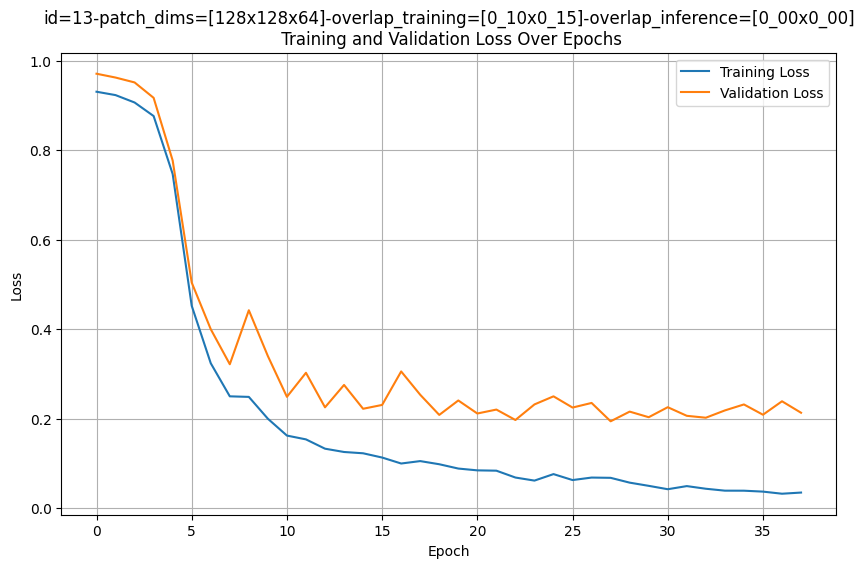

Best checkpoint path: /home/adrian/AIRT_Segmentation_Project/experimenting/training_validation/id=13-patch_dims=[128x128x64]-overlap_training=[0_10x0_15]-overlap_inference=[0_00x0_00]/best-checkpoint-epoch=27-val_loss=0.19.ckpt
Best epoch: 27.0
All dimensions are divisible by 32


/tmp/ipykernel_714218/3083895650.py:171: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("viridis", num_classes)


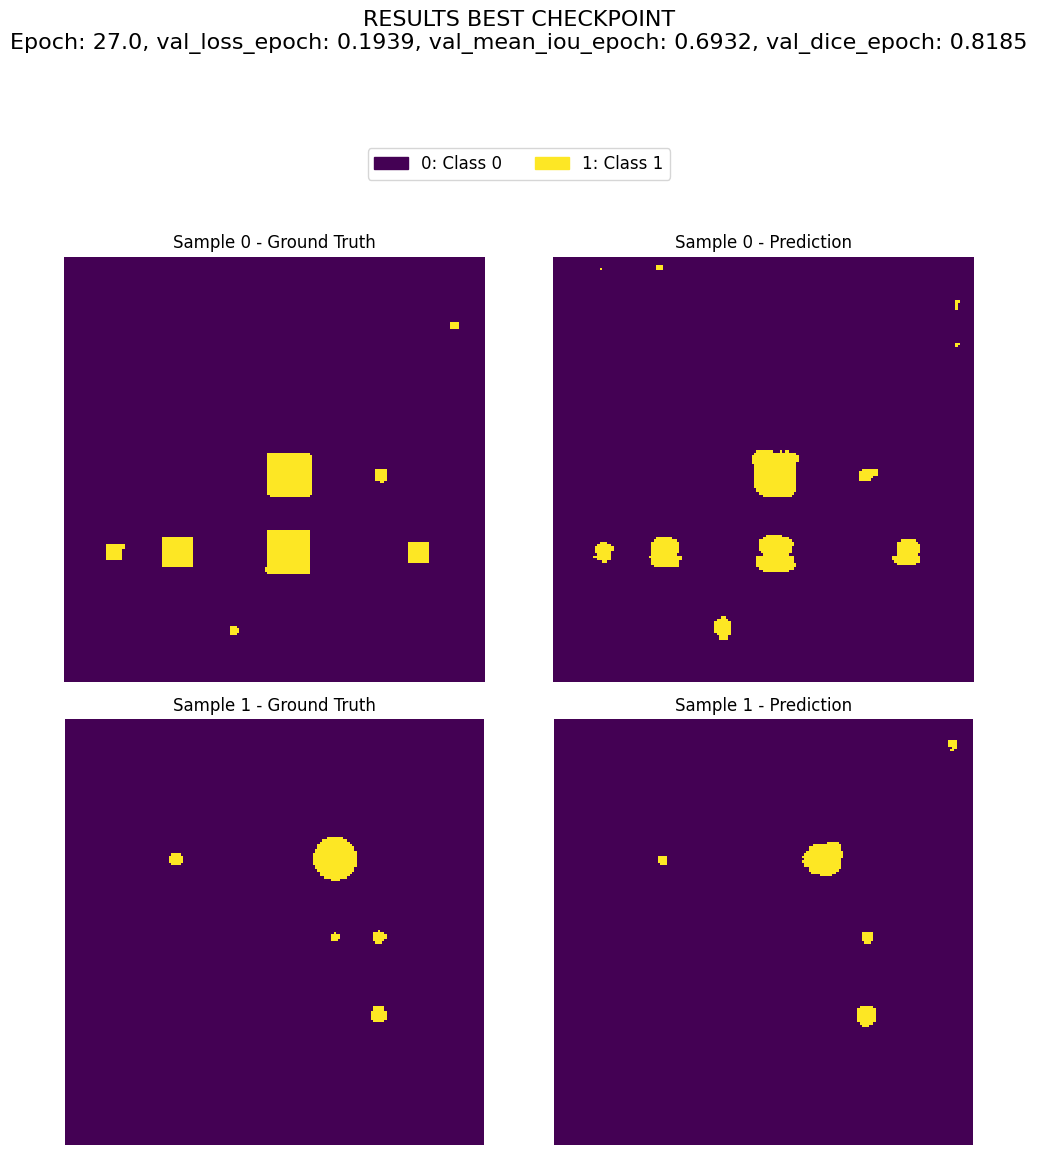

Combined inference plot saved at: training_validation/id=13-patch_dims=[128x128x64]-overlap_training=[0_10x0_15]-overlap_inference=[0_00x0_00]/results_best-checkpoint-epoch=27-val_loss=0.19.ckpt.png


In [14]:
import time

####################################################################################
#############################TRAINING###############################################
####################################################################################
# Measure start time
start_time = time.time()

# Train the model
model = SwinUNETR_AIRT_LightningModel(patch_dimensions=patch_dims)
# Fit the model
trainer.fit(model, train_loader, val_loader)

# Measure end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time // 3600:.0f}h {elapsed_time % 3600 // 60:.0f}m {elapsed_time % 60:.0f}s")

# When you call trainer.fit(), by default, PyTorch Lightning performs a "sanity check" on the validation data
# before the first training epoch starts. This sanity check typically involves running a few batches
# (usually two by default) of the validation data to ensure that:
#
# 1. There are no issues with the validation loop or dataset.
# 2. The model can perform a forward and backward pass without errors.
####################################################################################
#######################PLOTTING TRAINING LOSSES#####################################
####################################################################################

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torch.nn.functional as F
import os
import pandas as pd

# Base directory for the logs
log_dir = execution_dir

# Path to the latest metrics file
metrics_file = os.path.join(log_dir, 'metrics.csv')

# Load the logged metrics
metrics_df = pd.read_csv(metrics_file)

# Ensure metrics_df is loaded
# Filter rows where train_loss_epoch and val_loss_epoch are not NaN
train_loss = metrics_df['train_loss_epoch'].dropna()
val_loss = metrics_df['val_loss_epoch'].dropna()

# Use the 'epoch' column as x-axis
epochs_train = metrics_df.loc[metrics_df['train_loss_epoch'].notna(), 'epoch']
epochs_val = metrics_df.loc[metrics_df['val_loss_epoch'].notna(), 'epoch']

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_train, train_loss, label="Training Loss")
plt.plot(epochs_val, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(experiment_config_id + "\n Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Save the plot to the folder
save_path = os.path.join(log_dir, f"loss-evol_{experiment_config_id}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
print(f"Losses Plot saved at: {save_path}")

plt.show()

########################################################################################################
#############################PLOTTING BEST_CHECKPOINT RESULTS###########################################
########################################################################################################


# Path to the best checkpoint
best_checkpoint_path = checkpoint_callback.best_model_path
print(f"Best checkpoint path: {best_checkpoint_path}")

# Extract the best epoch number from the checkpoint filename
best_epoch = float(best_checkpoint_path.split("best-checkpoint-")[1].split("epoch=")[1].split("-")[0]) # best-checkpoint-epoch=02-val_loss=0.85
print(f"Best epoch: {best_epoch}")

# Path to metrics.csv
metrics_file = os.path.join(execution_dir, "metrics.csv")

# Load metrics to extract val_loss_epoch, val_mean_iou_epoch, val_dice_epoch for the best epoch
metrics_df = pd.read_csv(metrics_file)

# Get metrics for the best epoch
metrics_for_best_epoch = metrics_df.loc[metrics_df['epoch'] == best_epoch]
val_loss_epoch = metrics_for_best_epoch.loc[metrics_for_best_epoch['val_loss_epoch'].notna(), 'val_loss_epoch'].values[0]
val_mean_iou_epoch = metrics_for_best_epoch.loc[metrics_for_best_epoch['val_mean_iou_epoch'].notna(), 'val_mean_iou_epoch'].values[0]
val_dice_epoch = metrics_for_best_epoch.loc[metrics_for_best_epoch['val_dice_epoch'].notna(), 'val_dice_epoch'].values[0]

# Titles for the plots
plot_title_template = (
    f"Epoch: {best_epoch:.1f}, "
    f"val_loss_epoch: {val_loss_epoch:.4f}, "
    f"val_mean_iou_epoch: {val_mean_iou_epoch:.4f}, "
    f"val_dice_epoch: {val_dice_epoch:.4f}"
)

# Load the best checkpoint
best_model = SwinUNETR_AIRT_LightningModel.load_from_checkpoint(
    checkpoint_path=best_checkpoint_path,
    patch_dimensions=patch_dims  # Manually pass required arguments
)
best_model.eval()  # Set model to evaluation mode
best_model.freeze()  # Freeze the model

# Initialize lists to collect all results
all_ground_truth = []
all_predictions = []

# Inference on validation set
for batch_idx, batch in enumerate(val_loader):
    x, y = batch  # x: list of dict_patches, y: list of label_paths

    for sample_x, sample_y in zip(x, y):
        # Load ground truth
        y = torch.load(sample_y, weights_only=True).to(best_model.device)  # Move to the correct device
        y = y.unsqueeze(0)  # Add 1 dimension to match model output format

        # Create a tensor filled with NaN values
        y_hat = torch.empty_like(y).fill_(float('nan')).to(best_model.device)
        patches_dict_info = sample_x

        for patch_key in list(patches_dict_info.keys()):
            patch_coordinates = patches_dict_info[patch_key]["patch_coord"]
            patch_path = patches_dict_info[patch_key]["patch_path"]
            patch_tensor = torch.load(patch_path, weights_only=True).to(best_model.device)
            patch_tensor = patch_tensor.unsqueeze(0)  # Match model input format
            patch_prediction = best_model(patch_tensor)

            # Fill y_hat with patch predictions
            for i in range(patch_coordinates[0], patch_coordinates[0] + best_model.patch_dimensions[0]):
                for j in range(patch_coordinates[1], patch_coordinates[1] + best_model.patch_dimensions[1]):
                    is_pixel_without_prediction = torch.isnan(y_hat[:, :, i, j]).any()
                    if is_pixel_without_prediction:
                        y_hat[:, :, i, j] = patch_prediction[:, :, i - patch_coordinates[0], j - patch_coordinates[1]]

        # Apply softmax to probabilities (POST-PROCESSING)
        y_hat_probabilities = F.softmax(y_hat, dim=1)

        # Classify each pixel accoring to probabilties assigning the class with higher probabilty
        y_hat_categorized = torch.argmax(y_hat_probabilities.squeeze(), dim=0)
        # Convert y one_encoded into categorized tensor
        y = torch.argmax(y.squeeze(), dim=0)

        # Append to the global list
        all_ground_truth.append(y)
        all_predictions.append(y_hat_categorized)

# Find unique classes dynamically
all_classes = set()
for gt, pred in zip(all_ground_truth, all_predictions):
    all_classes.update(torch.unique(gt).tolist())  # Add classes from ground truth
    all_classes.update(torch.unique(pred).tolist())  # Add classes from predictions

# Sort the classes to ensure order
all_classes = sorted(all_classes)

# Define class labels dynamically (for simplicity, use numeric labels for now)
class_labels = {cls: f"Class {cls}" for cls in all_classes}
num_classes = len(class_labels)

# Create a discrete colormap with exactly `num_classes` colors
colormap = plt.cm.get_cmap("viridis", num_classes)

# Create legend patches using discrete colors from the colormap
legend_patches = [
    mpatches.Patch(color=colormap(i), label=f"{i}: {label}")
    for i, label in class_labels.items()
]

# Plot all results together
num_samples = len(all_ground_truth)

# Create the figure
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

# Ensure axes is always 2D
if num_samples == 1:
    axes = axes[None, :]  # Ensure axes is 2D when there's only one sample

# Plot ground truth and predictions
for sample_idx, (ground_truth, prediction) in enumerate(zip(all_ground_truth, all_predictions)):
    # Ground truth
    im_gt = axes[sample_idx, 0].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
    axes[sample_idx, 0].set_title(f"Sample {sample_idx} - Ground Truth")
    axes[sample_idx, 0].axis("off")

    # Prediction
    im_pred = axes[sample_idx, 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
    axes[sample_idx, 1].set_title(f"Sample {sample_idx} - Prediction")
    axes[sample_idx, 1].axis("off")

# Add a single legend for the entire figure
fig.legend(
    handles=legend_patches,
    loc="upper center",
    ncol=num_classes,
    bbox_to_anchor=(0.5, 1.02),
    fontsize=12
)

# Add a title for the entire figure
fig.suptitle("RESULTS BEST CHECKPOINT\n" + plot_title_template, fontsize=16, y=1.15)
plt.tight_layout()

# Save the combined plot
combined_plot_path = os.path.join(execution_dir, f"results_{best_checkpoint_path.split('/')[-1]}.png")
plt.savefig(combined_plot_path, dpi=300, bbox_inches="tight")
plt.show()

plt.close(fig)

print(f"RESULTS BEST CHECKPOINT plot saved at: {combined_plot_path}")
